In [1]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

Connection to online passbands at http://tables.phoebe-project.org could not be established.  Check your internet connection or try again later (can manually call phoebe.list_online_passbands(refresh=True) to retry).  If the problem persists and you're using a Mac, you may need to update openssl (see http://phoebe-project.org/help/faq). Original error from urlopen: URLError <urlopen error [Errno -2] Name or service not known>


In [20]:
b = phoebe.load("../estimations/aviles-data-bundle-saves/ebai-estimates")

In [21]:
# loading full Iturbide observations to compare results
import pandas as pd

OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
CONCAT_OBSERVATIONS_CSV = f"{OBJ_DATA_DIR}/culledObjData.csv"
iturbideObservations = pd.read_csv(CONCAT_OBSERVATIONS_CSV, index_col=0)

b.add_dataset('lc', dataset='lc_iturbide_full_raw', overwrite=True,
              times=iturbideObservations['julianDate'].to_numpy()*u.day, 
              fluxes=iturbideObservations['FLUX'].to_numpy(), sigmas=iturbideObservations['FERR'].to_numpy(),
			  pblum_mode="dataset-scaled")

<ParameterSet: 47 parameters | contexts: compute, figure, dataset, constraint>

In [51]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
allRawDatasets = rawGaiaDatasets + ['lc_iturbide_raw', 'lc_iturbide_full_raw']
rawOptDatasets = rawGaiaDatasets + ['lc_iturbide_raw']

def printChi2(b: phoebe.Bundle, model: str):
	print(model, "-------------------------------------", sep='\n')
	try:
		print('\t', "Iturbide (Aviles) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_raw')))
	except: pass

	try:
		print('\t', "Iturbide (Full) -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_full_raw')))
	except: pass

	try:
		print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	except: pass

	try:
		for gd in rawGaiaDatasets:
			print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))
	except: pass

def printAllModelsChi2(b: phoebe.Bundle):
	for m in b.models:
		printChi2(b, m)

Thu, 26 Oct 2023 14:36 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1964/1964 [02:49<00:00, 11.61it/s]
Thu, 26 Oct 2023 14:39 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


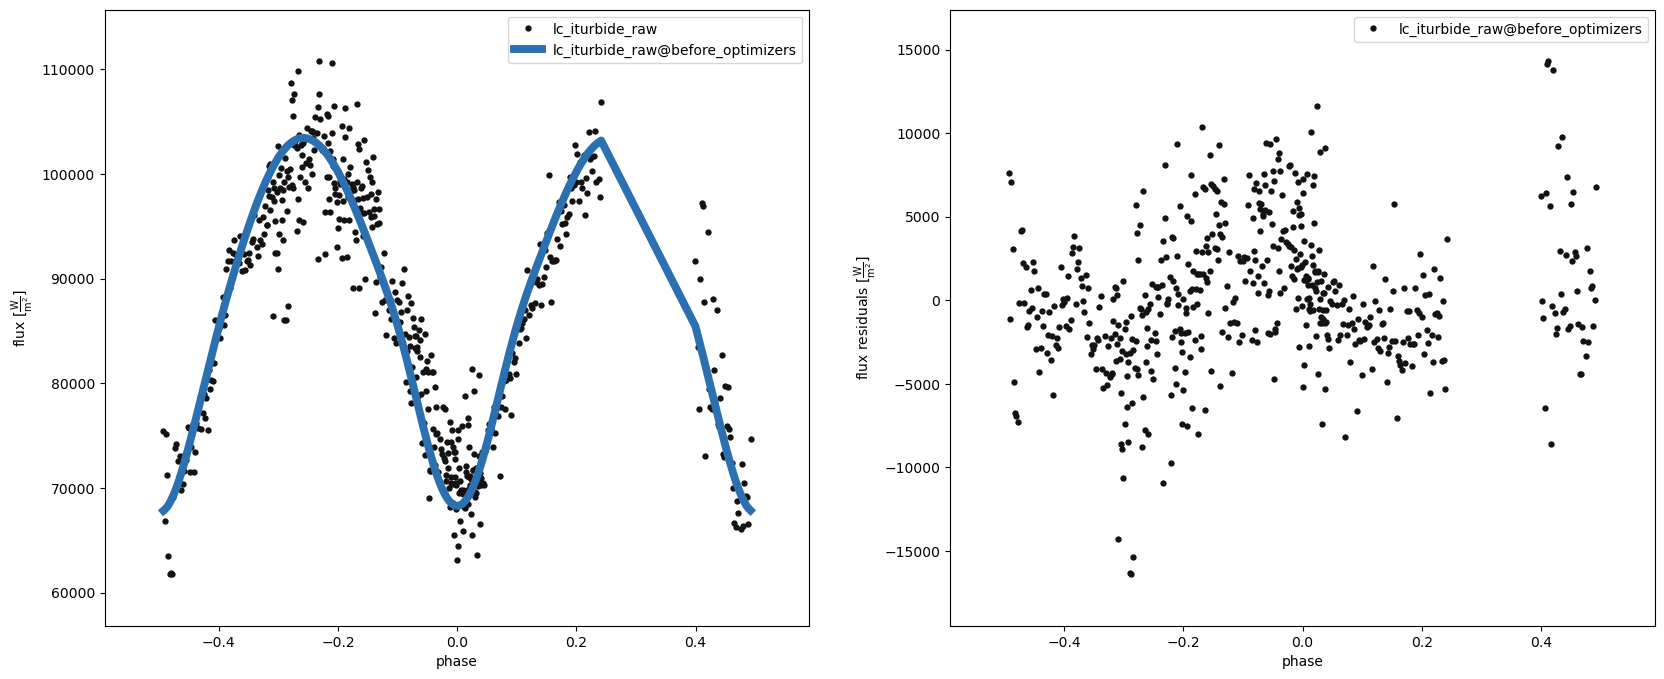

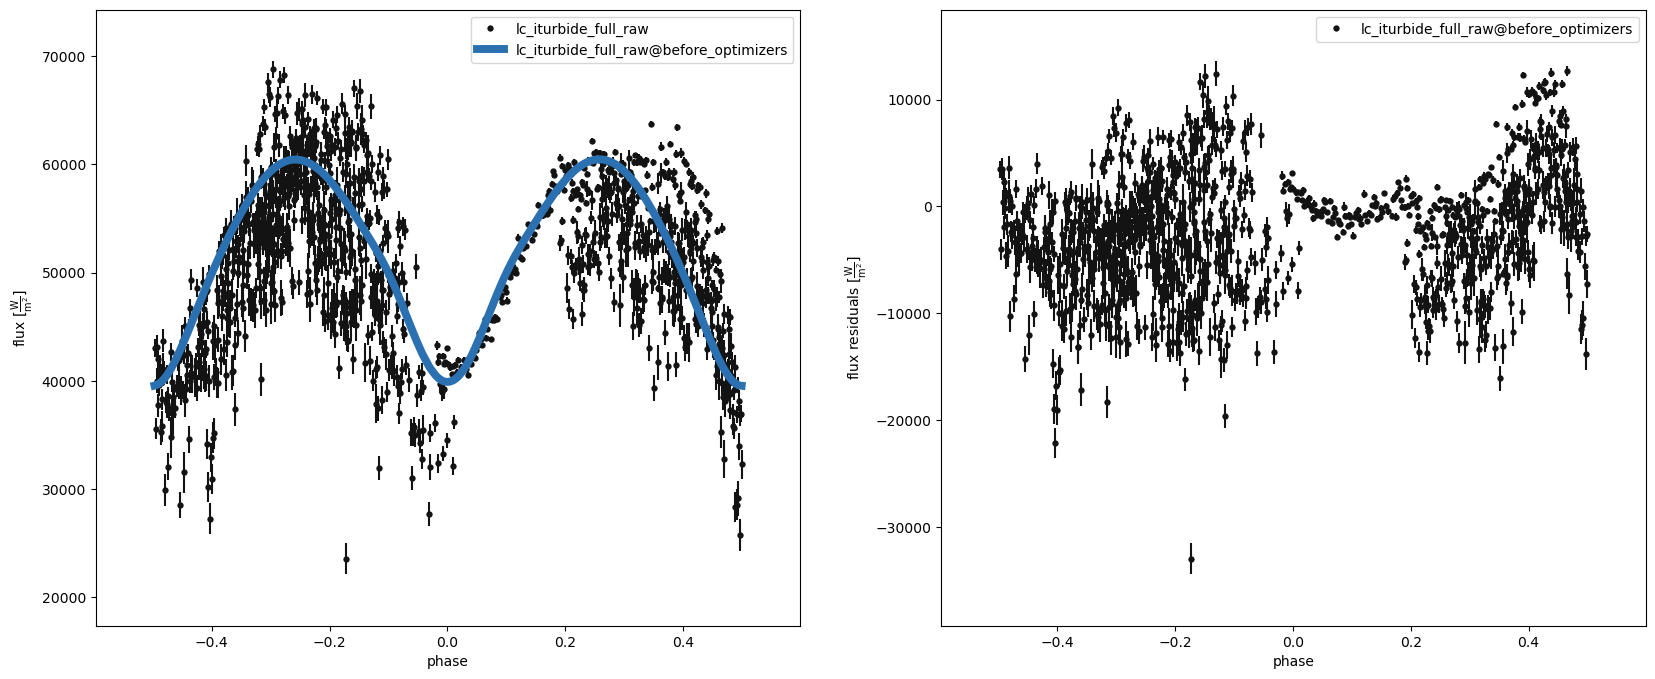

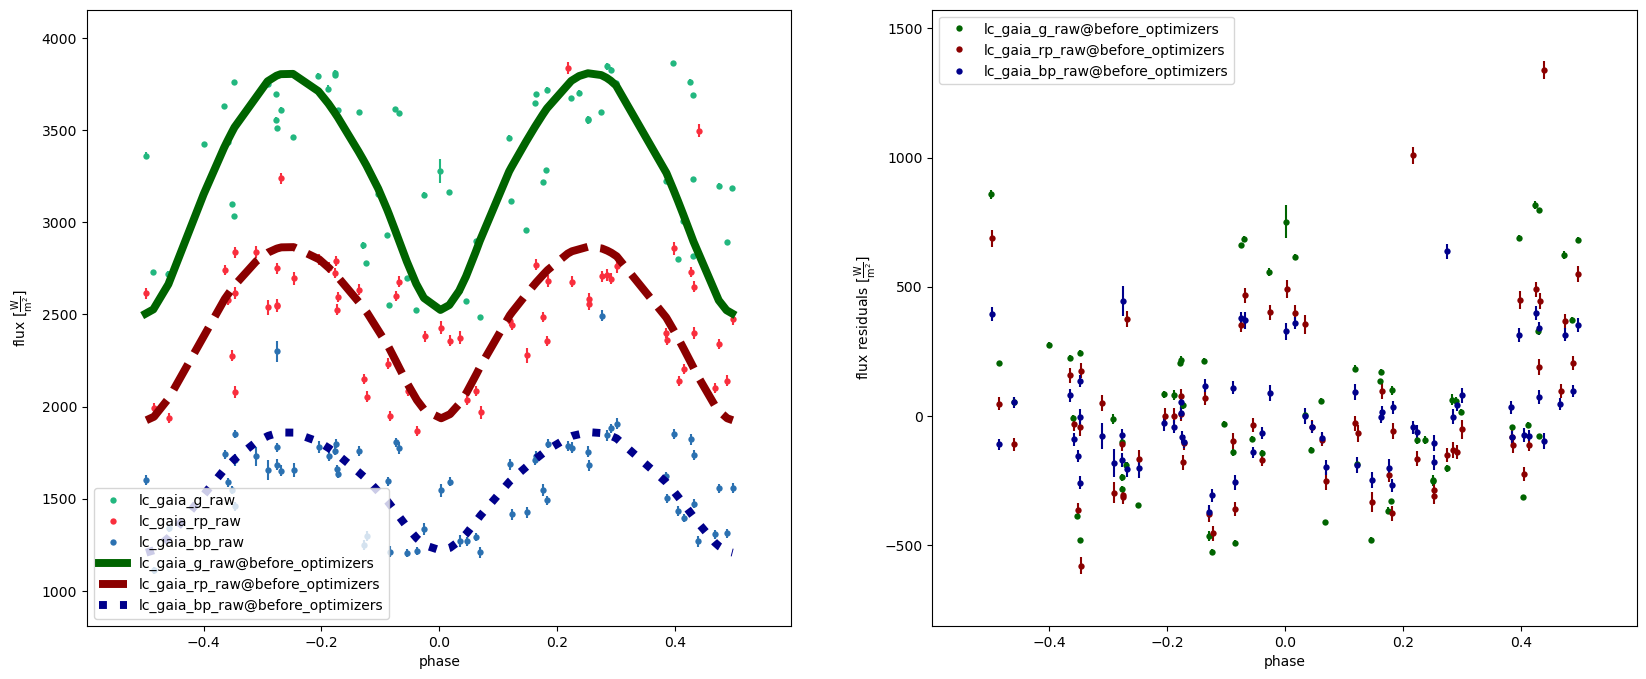

before_optimizers
-------------------------------------
	 Iturbide - 9878882142.08559
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079


In [24]:
gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model='before_optimizers', overwrite=True)

gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model='before_optimizers')
printChi2(b, "before_optimizers")

In [25]:
print(b['mass'])
print(b['q'])
print(1/b['value@q'])
print(b['sma'])

ParameterSet: 4 parameters
C          mass@primary@component: 1.0087816199638129 solMass
C        mass@secondary@component: 3.525636912291516 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 3.494945627992298
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, sma@primary

## Poro et al. (2021) Priors

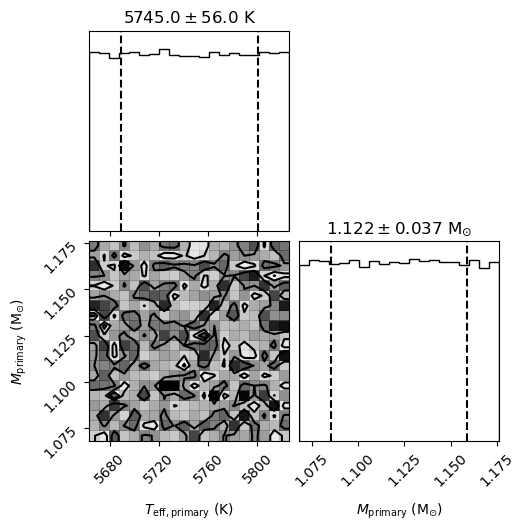

In [26]:
b.flip_constraint(qualifier='mass', component='primary', solve_for='sma@binary')

# Poro et al. (2021) [Investigation of P_orb and other params relationships]
# using uninformative uniform priors; mainly looking to restrict optimizer parameter space
p_orb = b.get_value(qualifier='period', component='binary')

# primary T_eff
upperTeffPrimary = (6951.42 + 112.16)*p_orb + (3426.01 + 44.12)
lowerTeffPrimary = (6951.42 - 112.68)*p_orb + (3426.01 - 43.90)

# primary mass
upperMassPrimary = (2.924 + 0.075)*p_orb + (0.147 + 0.029)
lowerMassPrimary = (2.924 - 0.075)*p_orb + (0.147 - 0.029)

b.add_distribution({
	'teff@primary': phoebe.uniform(high=upperTeffPrimary, low=lowerTeffPrimary, unit=u.K),
	'mass@primary': phoebe.uniform(high=upperMassPrimary, low=lowerMassPrimary, unit=u.solMass)
}, distribution='poro_porb_bounds', overwrite_all=True)

_ = b.plot_distribution_collection(distribution='poro_porb_bounds', show=True)

## Trimming the Bundle

Removing unused datasets and models from estimators to de-clutter bundle and decrease bundle size.

In [45]:
b.models, b.datasets

(['full_default',
  'raw_model',
  'ebai_knn_model',
  'ebai_knn_lc_iturbide_model',
  'ebai_knn_lc_gaia_g_model',
  'ebai_knn_lc_gaia_rp_model',
  'ebai_knn_lc_gaia_bp_model',
  'ebai_knn_lc_iturbide_raw_model',
  'ebai_knn_lc_gaia_g_raw_model',
  'ebai_knn_lc_gaia_rp_raw_model',
  'ebai_knn_lc_gaia_bp_raw_model',
  'ebai_knn_raw_model',
  'ebai_knn_raw_gaia_model',
  'before_optimizers',
  'opt_period_t0_model',
  'opt_incl_model',
  'opt_incl_q_model'],
 ['mesh01',
  'lc_iturbide',
  'lc_iturbide_raw',
  'lc_gaia_g',
  'lc_gaia_rp',
  'lc_gaia_bp',
  'lc_gaia_g_raw',
  'lc_gaia_rp_raw',
  'lc_gaia_bp_raw',
  'lc_iturbide_full_raw'])

In [47]:
for m in b.models:
	if m.startswith('ebai'):
		b.remove_model(m)

for d in ['lc_iturbide', 'lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp']:
	b.remove_dataset(d)

## Period and `t0_supconj`

In [ ]:
opt_utils.optimize_params(b, ['t0_supconj', 'period@binary'], label='period_t0', export=True, datasets=allRawDatasets, maxiter=200)

Adopted:
t0_supconj@binary@orbit@component = 0.07183 d
period@binary@orbit@component = 0.33354 d

Original values:
  t0_supconj@binary@orbit@component 0.06841024400254482 d
  period@binary@orbit@component 0.3335413827524847 d


Thu, 26 Oct 2023 14:46 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1948/1948 [02:43<00:00, 11.91it/s]
Thu, 26 Oct 2023 14:49 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


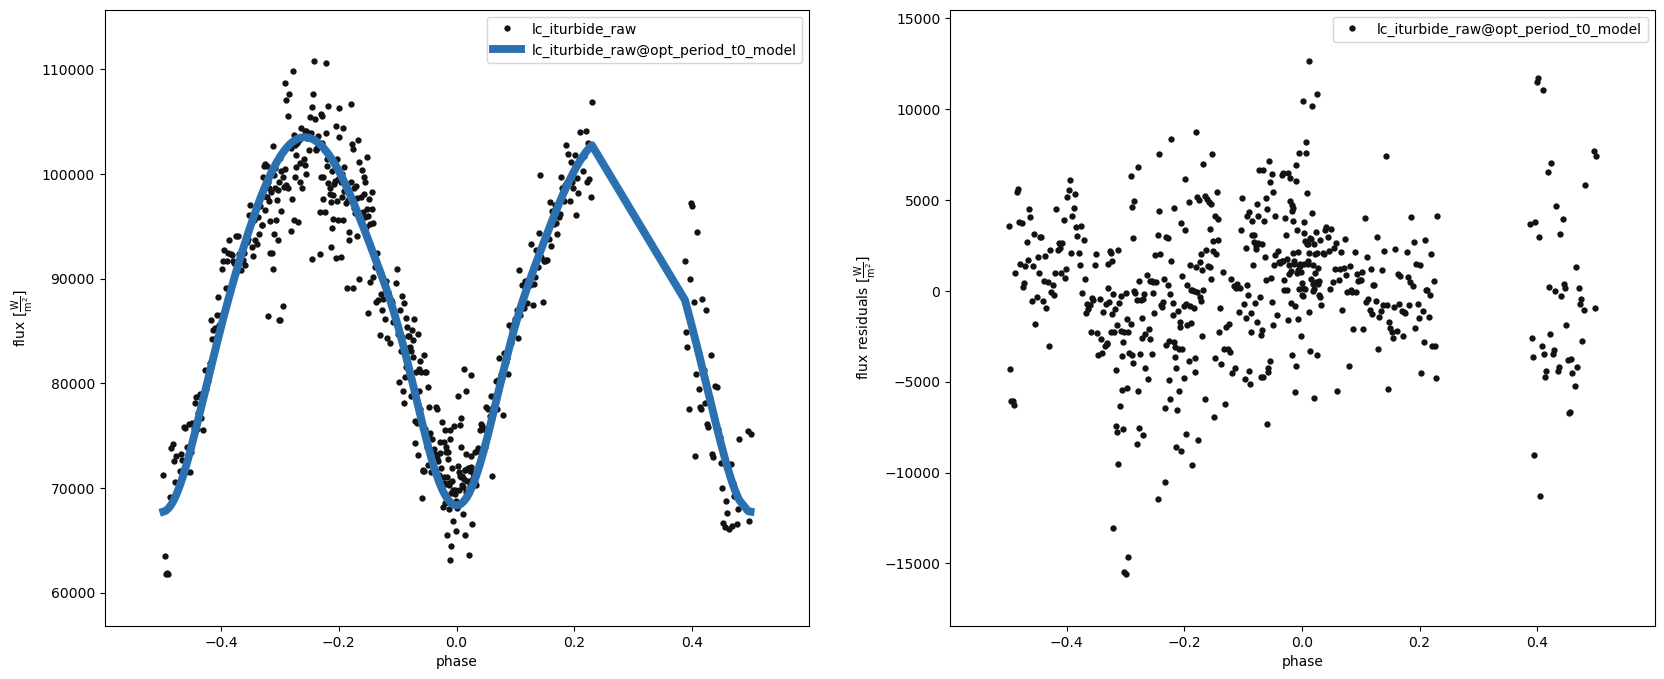

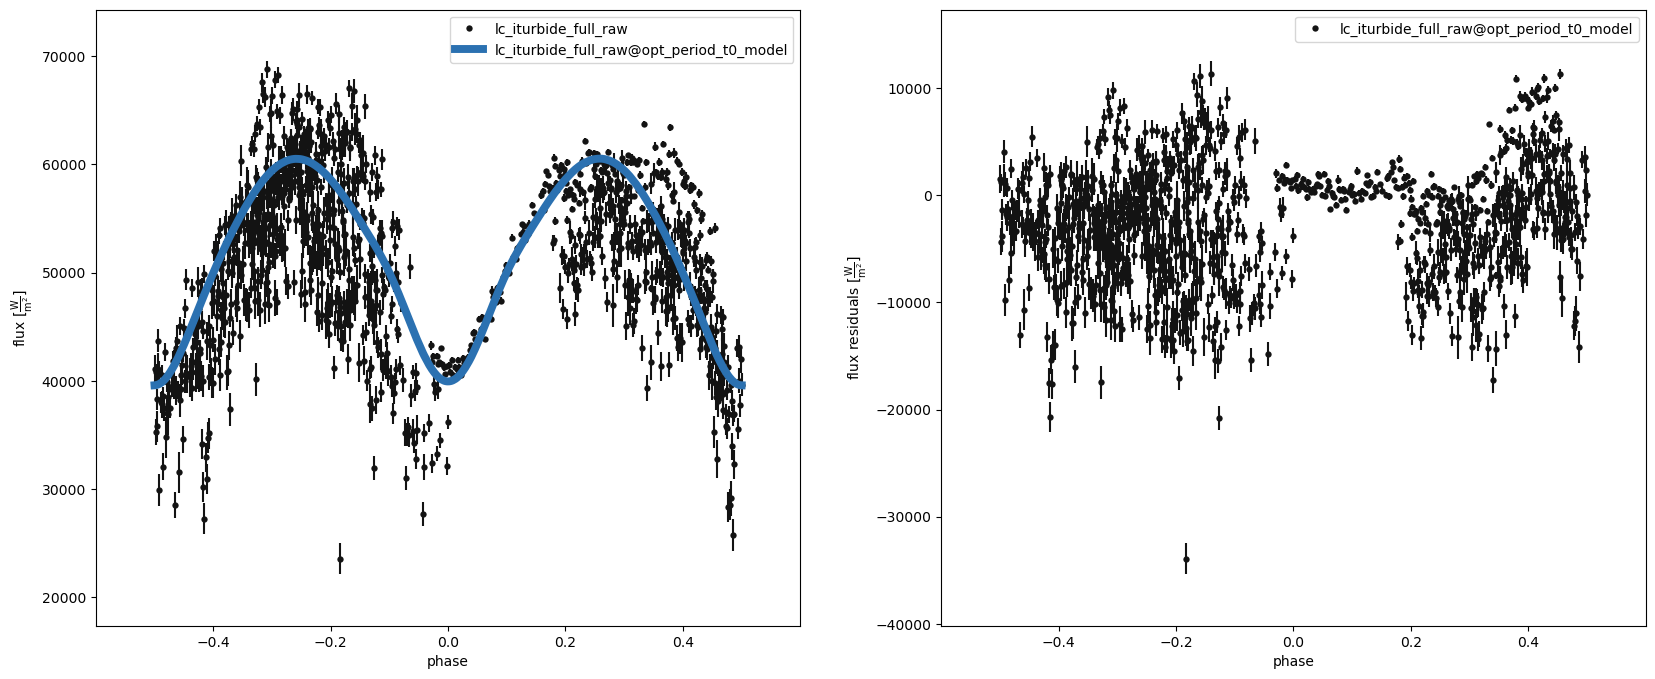

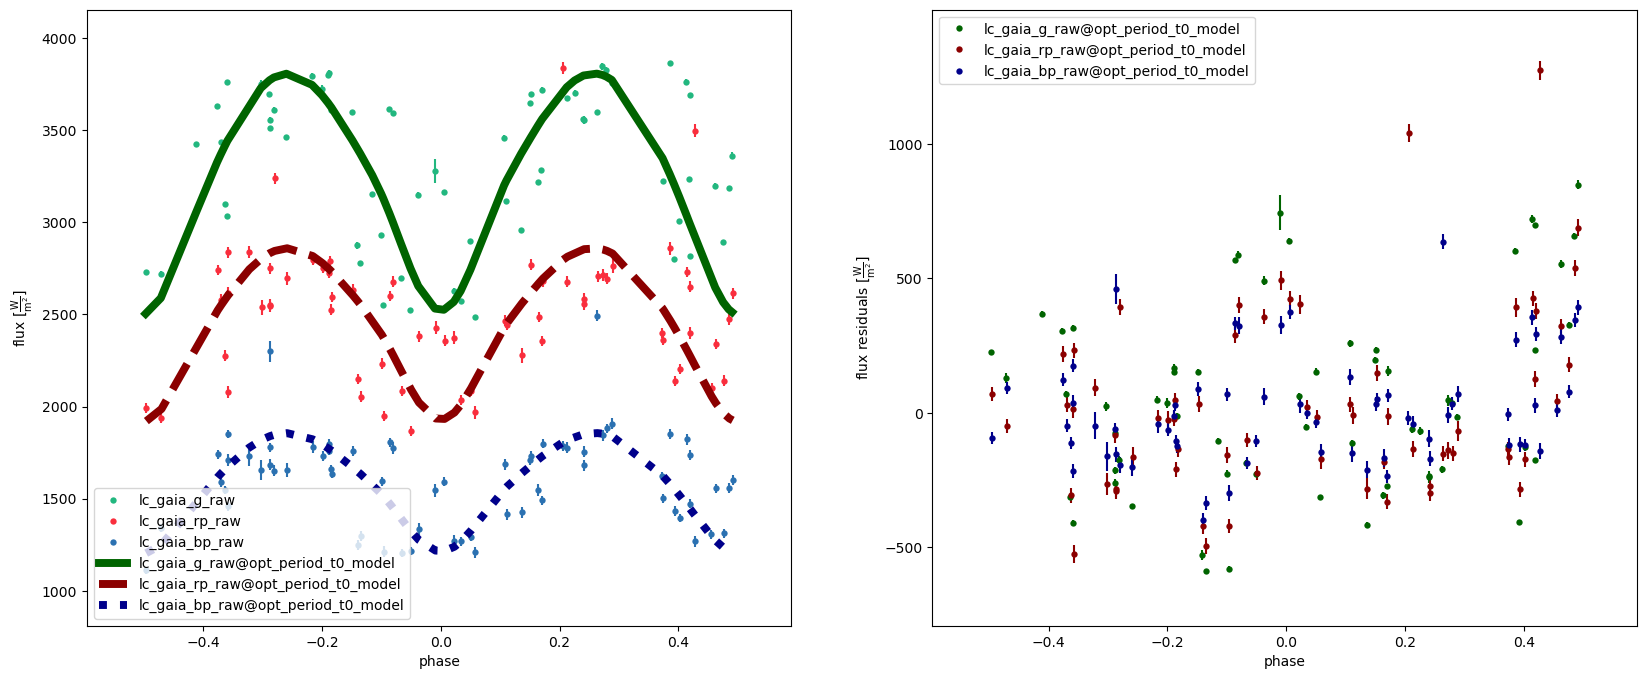

before_optimizers
-------------------------------------
	 Iturbide - 9878882142.08559
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
opt_period_t0_model
-------------------------------------
	 Iturbide - 8396815354.846167
	 Gaia - 77188.51758182517
		 lc_gaia_g_raw - 66206.23421159203
		 lc_gaia_rp_raw - 7463.588528353623
		 lc_gaia_bp_raw - 3518.69484187952


In [28]:
solutionName, computeModelName = opt_utils.adopt_solution(b, 'period_t0', reset_params=False, 
                                                          solution_file="./aviles-data-external-jobs/results/opt_period_t0_solution", plot=False, 
                                                          dataset=allRawDatasets)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model=computeModelName)
printChi2(b, 'before_optimizers')
printChi2(b, computeModelName)

## Width and depth of eclipses

`teffratio`, `fillout_factor`
* Testing out `fillout_factor` for parametrization of the shapes of the stars instead of manipulating their equivalent radii

In [8]:
backup = b.copy()

In [44]:
b = backup.copy()

In [46]:
print(b['requiv'])
print(b['requivsumfrac'])
print(b['requivratio'])
print(b['teffratio'])
print(b['mass'])
print(b['sma@binary'])
print(b['pot'])
print(b['fillout_factor'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.0337700401734613 solRad
C      requiv@secondary@component: 1.7436624098728664 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
ParameterSet: 2 parameters
C  requivsumfrac@binary@component: 0.8290843134466649
         requivsumfrac@constraint: ({requiv@primary@component} + {requiv@secondary@component}) / {sma@binary@component}
ParameterSet: 2 parameters
C    requivratio@binary@component: 1.686702401996762
           requivratio@constraint: {requiv@secondary@component} / {requiv@primary@component}
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                          

### `lc_gaia_g` only

In [56]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_gaiag', 
						  export=True, datasets=['lc_gaia_g_raw'], maxiter=250)

ParameterSet: 9 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide@phoebe0...: False
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
External Solver: ./external-jobs/optimizer.nelder_mead_opt_teffratio_ff_gaiag.py ./results/opt_teffratio_ff_gaiag_solution
('opt_teffratio_ff_gaiag', 'opt_teffratio_ff_gaiag_solution')
ParameterSet: 9 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide@phoebe0...: False
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True


In [12]:
gen_utils.abilitateDatasets(b, allRawDatasets)
print(b['enabled'])

ParameterSet: 9 parameters
   enabled@mesh01@phoebe01@com...: False
   enabled@lc_iturbide@phoebe0...: True
   enabled@lc_iturbide_raw@pho...: False
   enabled@lc_gaia_g@phoebe01@...: False
   enabled@lc_gaia_rp@phoebe01...: False
   enabled@lc_gaia_bp@phoebe01...: False
   enabled@lc_gaia_g_raw@phoeb...: False
   enabled@lc_gaia_rp_raw@phoe...: False
   enabled@lc_gaia_bp_raw@phoe...: False


Adopted:
teffratio@binary@orbit@component = 0.96632 
fillout_factor@contact_envelope@envelope@component = 0.03782 

Original values:
  teffratio@binary@orbit@component 0.9956047098450885
  fillout_factor@contact_envelope@envelope@component 0.5164011874682658


100%|██████████| 763/763 [01:56<00:00,  6.57it/s]
Wed, 20 Sep 2023 16:30 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


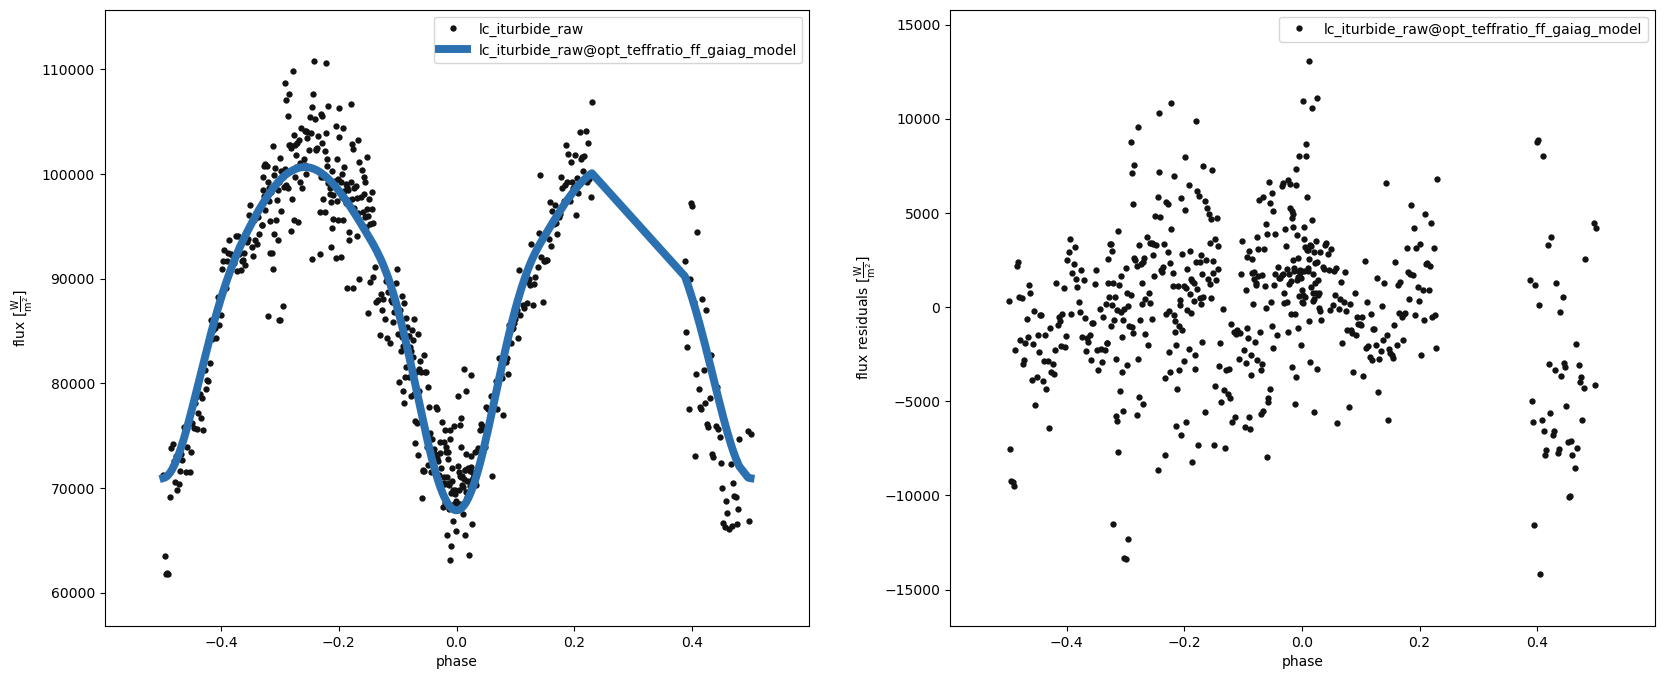

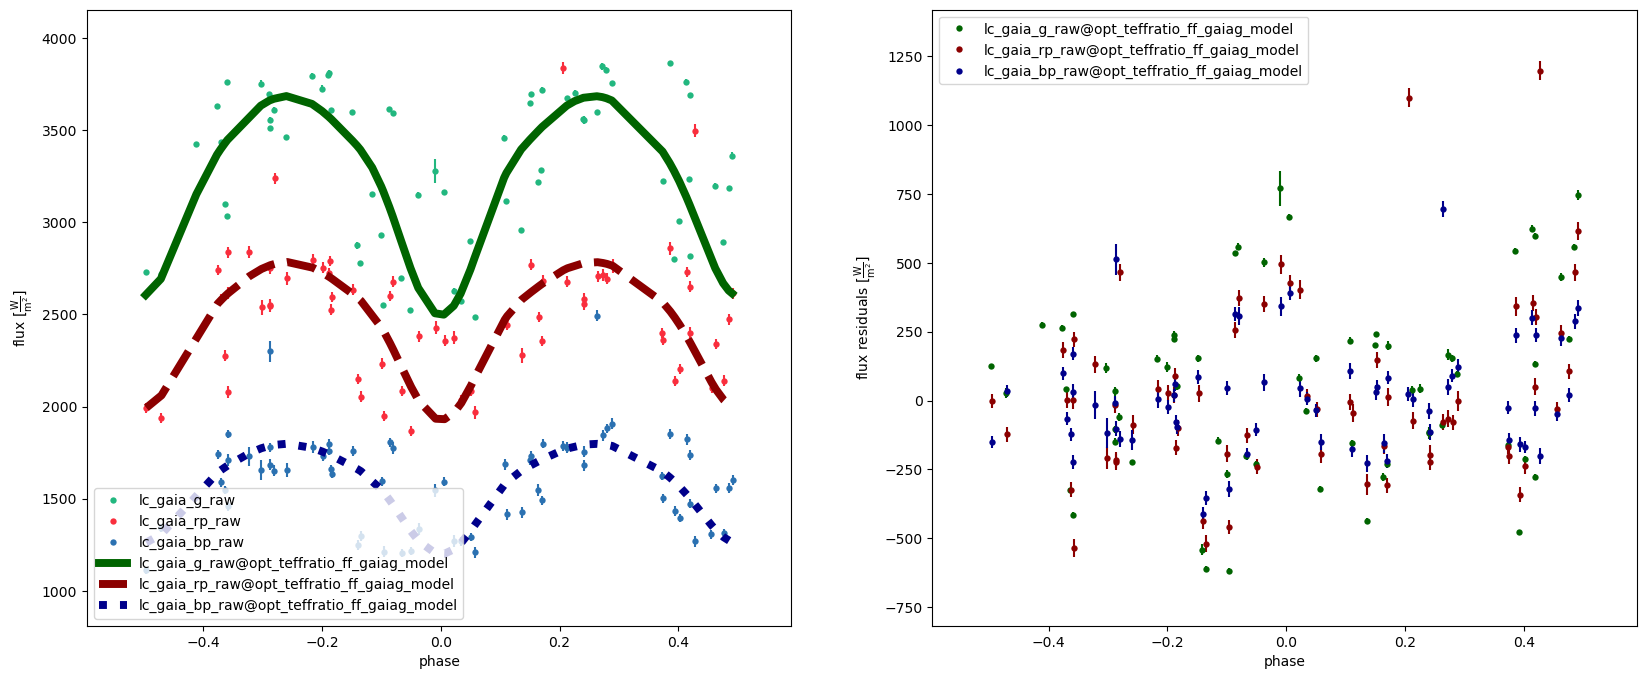

In [13]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./aviles-data-external-jobs/results/opt_teffratio_ff_gaiag_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [14]:
keepModels = ['before_optimizers'] + [m for m in b.models if 'opt' in m]
for m in b.models:
	if m not in keepModels:
		b.remove_model(m)
b.models

['before_optimizers', 'opt_period_t0_model', 'opt_teffratio_ff_gaiag_model']

In [15]:
printChi2(b, 'before_optimizers')
printChi2(b, 'opt_period_t0_model')
printChi2(b, 'opt_teffratio_ff_gaiag_model')

before_optimizers
-------------------------------------
	 Iturbide - 9878631248.14905
	 Gaia - 85201.17598036204
		 lc_gaia_g_raw - 73694.63425580358
		 lc_gaia_rp_raw - 7803.496228842397
		 lc_gaia_bp_raw - 3703.0454957160496
opt_period_t0_model
-------------------------------------
	 Iturbide - 8397557646.504897
	 Gaia - 77192.26270095682
		 lc_gaia_g_raw - 66209.37046530753
		 lc_gaia_rp_raw - 7463.899781750353
		 lc_gaia_bp_raw - 3518.992453898948
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 8907980667.821335
	 Gaia - 69193.7430920128
		 lc_gaia_g_raw - 58790.434563996445
		 lc_gaia_rp_raw - 6982.790566998524
		 lc_gaia_bp_raw - 3420.517961017837


### `lc_iturbide` only

In [10]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_iturbide', 
						  export=True, datasets=['lc_iturbide_raw'], maxiter=250)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_teffratio_ff_iturbide.py ./results/opt_teffratio_ff_iturbide_solution


('opt_teffratio_ff_iturbide', 'opt_teffratio_ff_iturbide_solution')

Adopted:
teffratio@binary@orbit@component = 1.02235 
fillout_factor@contact_envelope@envelope@component = 0.33163 

Original values:
  teffratio@binary@orbit@component 0.9956047098450885
  fillout_factor@contact_envelope@envelope@component 0.5164011874682658


100%|██████████| 763/763 [01:36<00:00,  7.94it/s]
Wed, 20 Sep 2023 16:35 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


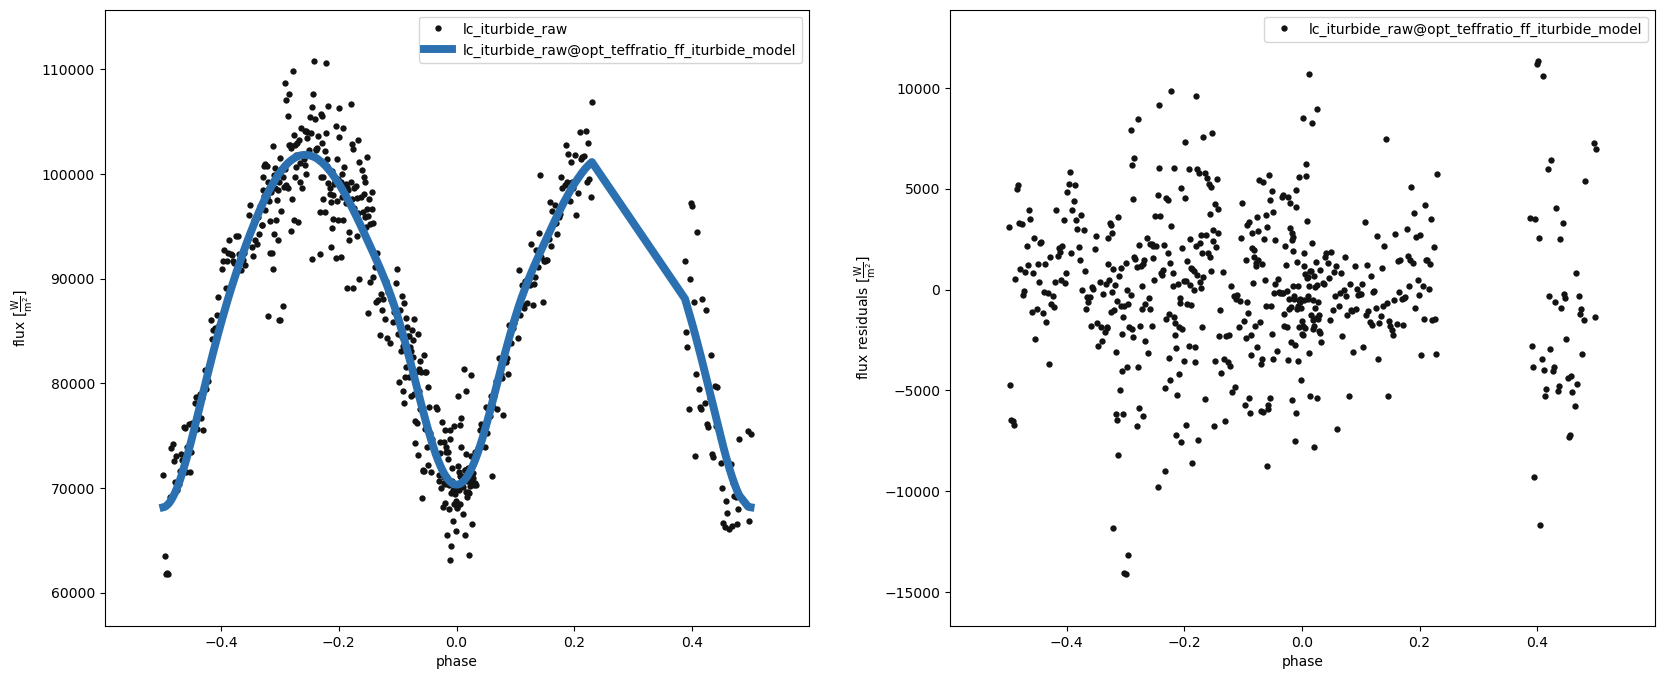

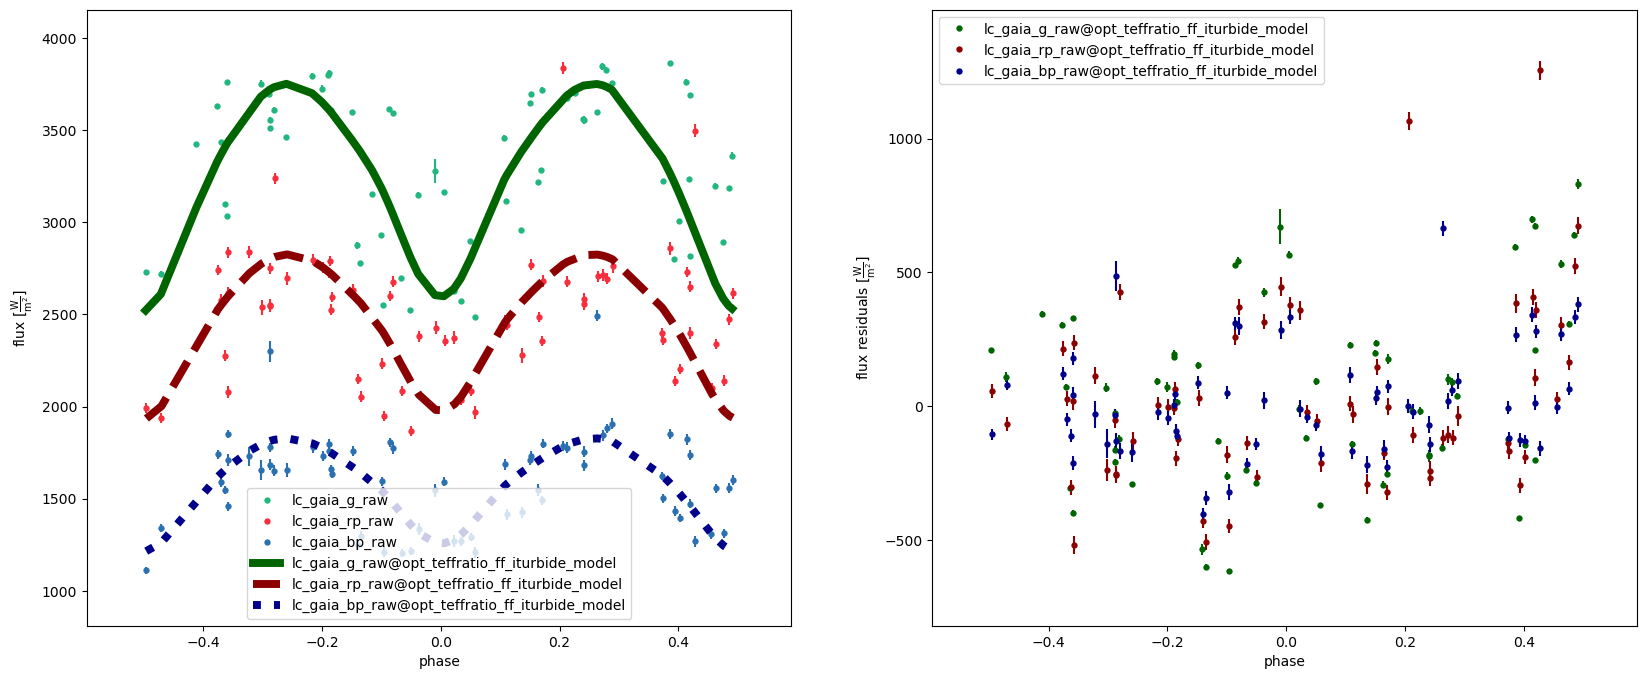

In [16]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./aviles-data-external-jobs/results/opt_teffratio_ff_iturbide_solution", reset_params=True, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], rawGaiaDatasets], model=computeModelName, legend=True, marker={'dataset': '.'}, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [17]:
for m in b.models:
	printChi2(b, m)

before_optimizers
-------------------------------------
	 Iturbide - 9878631248.14905
	 Gaia - 85201.17598036204
		 lc_gaia_g_raw - 73694.63425580358
		 lc_gaia_rp_raw - 7803.496228842397
		 lc_gaia_bp_raw - 3703.0454957160496
opt_period_t0_model
-------------------------------------
	 Iturbide - 8397557646.504897
	 Gaia - 77192.26270095682
		 lc_gaia_g_raw - 66209.37046530753
		 lc_gaia_rp_raw - 7463.899781750353
		 lc_gaia_bp_raw - 3518.992453898948
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 8907980667.821335
	 Gaia - 69193.7430920128
		 lc_gaia_g_raw - 58790.434563996445
		 lc_gaia_rp_raw - 6982.790566998524
		 lc_gaia_bp_raw - 3420.517961017837
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 7526787405.610246
	 Gaia - 73439.38044855553
		 lc_gaia_g_raw - 62818.554578067226
		 lc_gaia_rp_raw - 7187.746111581734
		 lc_gaia_bp_raw - 3433.0797589065805


In [28]:
print(b['mass'])
print(b['q'], 1/b['value@q'])
print(b['incl@binary'])
print(b['requiv'])
print(b['fillout_factor'])
print(b['pot'])
print(b['teff'])
print(b['sma@binary'])

ParameterSet: 4 parameters
C          mass@primary@component: 1.0087816196188395 solMass
C        mass@secondary@component: 3.525636911085852 solMass
          mass@primary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ({q@binary@component} + 1.000000)) * 2942.206217504419328179210424423218)
        mass@secondary@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 3.494945627992298
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, sma@primary

### All datasets (Iturbide + Gaia | Raw datasets)

In [57]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], 'teffratio_ff_rawdata', 
						  export=True, datasets=allRawDatasets, maxiter=250)

External Solver: ./external-jobs/optimizer.nelder_mead_opt_teffratio_ff_rawdata.py ./results/opt_teffratio_ff_rawdata_solution


('opt_teffratio_ff_rawdata', 'opt_teffratio_ff_rawdata_solution')

Adopted:
teffratio@binary@orbit@component = 1.02131 
fillout_factor@contact_envelope@envelope@component = 0.32397 

Original values:
  teffratio@binary@orbit@component 0.9956047098450885
  fillout_factor@contact_envelope@envelope@component 0.5164011874682658


Thu, 26 Oct 2023 14:29 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.
100%|██████████| 1964/1964 [02:53<00:00, 11.30it/s]
Thu, 26 Oct 2023 14:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009904226117742074 for dataset='lc_iturbide'
Thu, 26 Oct 2023 14:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'
Thu, 26 Oct 2023 14:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Thu, 26 Oct 2023 14:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Thu, 26 Oct 2023 14:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


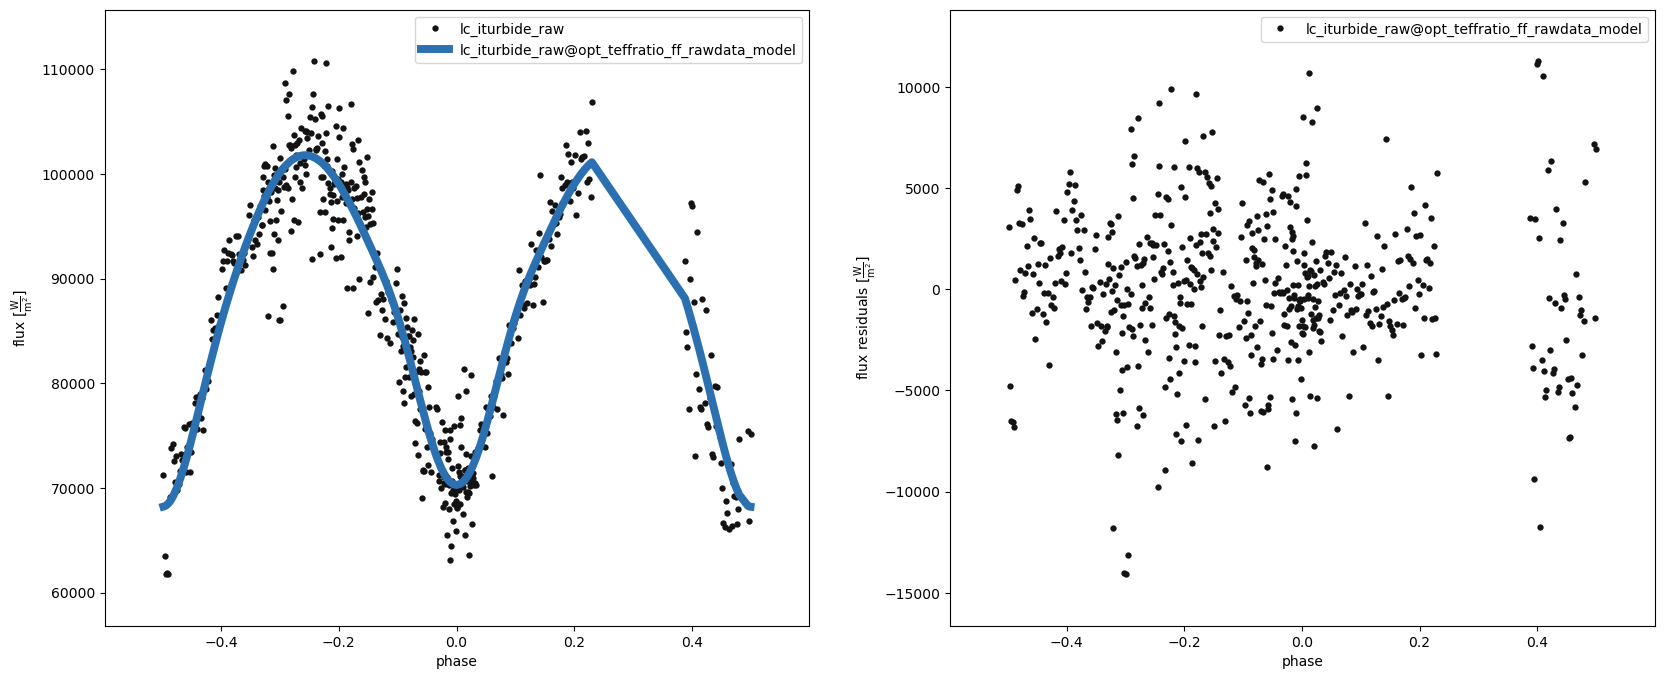

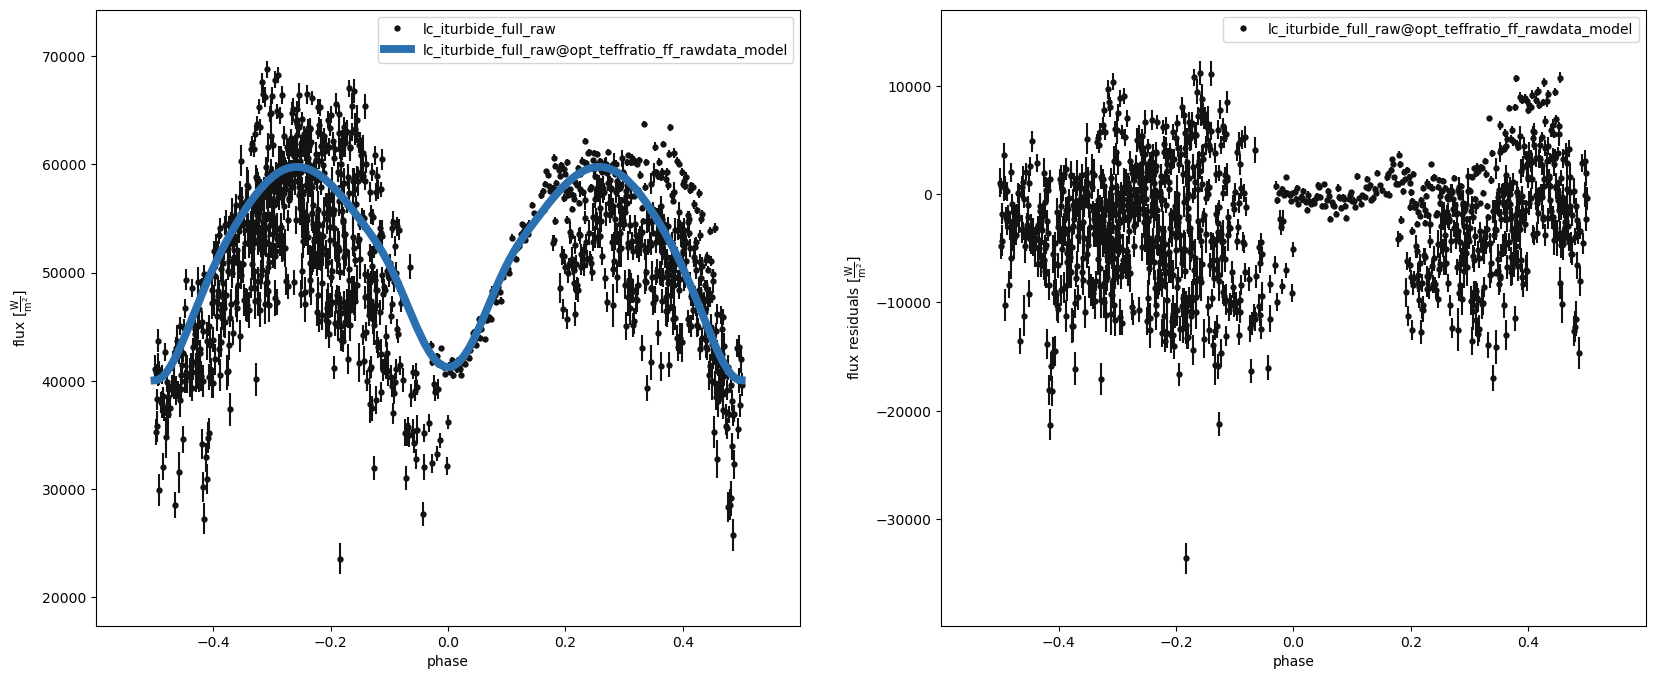

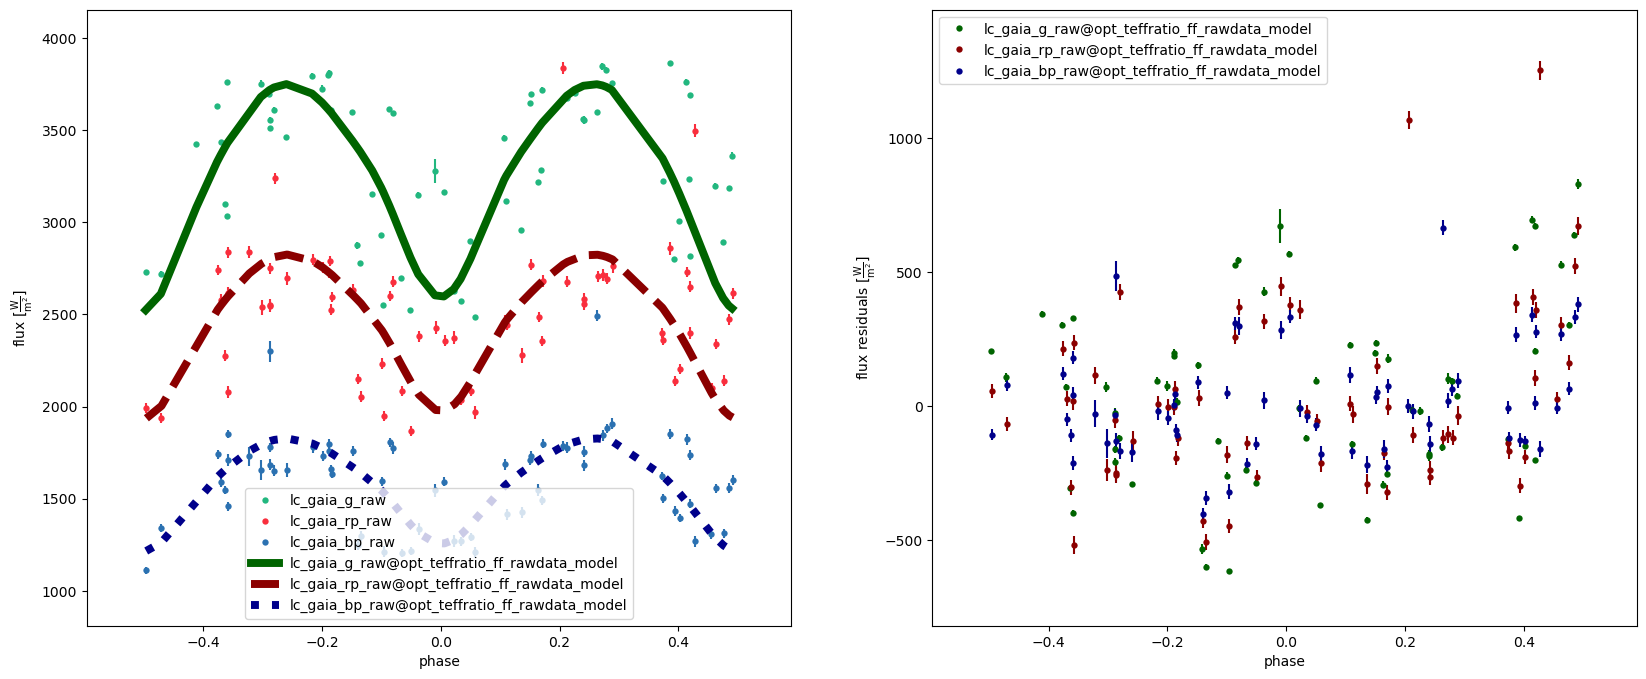

In [10]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./aviles-data-external-jobs/results/opt_teffratio_ff_rawdata_solution", reset_params=False, plot=False)
gen_utils.plotModelResidualsFigsize(b, (20,8), [['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model=computeModelName)

### Comparing the different solvers

In [19]:
for s in b.solutions:
	if 'opt' not in s:
		b.remove_solution(s)

b.solutions

['opt_period_t0_solution',
 'opt_teffratio_ff_gaiag_solution',
 'opt_teffratio_ff_iturbide_solution',
 'opt_teffratio_ff_rawdata_solution']

In [24]:
print(b['opt_period_t0_solution'])

ParameterSet: 11 parameters
R  fitted_twigs@opt_period_t0@...: ['t0_supconj@binary@orbit@component' 'period@binary@orbit@component']
   adopt_parameters@opt_period...: ['t0_supconj@binary@orbit@component', 'period@binary@orbit@component']
   adopt_distributions@opt_per...: False
   adopt_values@opt_period_t0@...: True
R  message@opt_period_t0@opt_p...: Maximum number of iterations has been exceeded.
R  niter@opt_period_t0@opt_per...: 150
R  success@opt_period_t0@opt_p...: False
R  initial_values@opt_period_t...: [0.07183033865425345 0.3335413828053897]
R  fitted_values@opt_period_t0...: [0.07183187311538936 0.33354138280951534]
R  fitted_units@opt_period_t0@...: ['d' 'd']
   comments@opt_period_t0@opt_...: 


In [20]:
for m in b.models:
	printChi2(b, m)

print("======================================")

for s in b.solutions:
	print(s, "---------------------------------------", sep='\n')
	gen_utils.printFittedVals(b, s)
	print()

before_optimizers
-------------------------------------
	 Iturbide - 9878631248.14905
	 Gaia - 85201.17598036204
		 lc_gaia_g_raw - 73694.63425580358
		 lc_gaia_rp_raw - 7803.496228842397
		 lc_gaia_bp_raw - 3703.0454957160496
opt_period_t0_model
-------------------------------------
	 Iturbide - 8397557646.504897
	 Gaia - 77192.26270095682
		 lc_gaia_g_raw - 66209.37046530753
		 lc_gaia_rp_raw - 7463.899781750353
		 lc_gaia_bp_raw - 3518.992453898948
opt_teffratio_ff_gaiag_model
-------------------------------------
	 Iturbide - 8907980667.821335
	 Gaia - 69193.7430920128
		 lc_gaia_g_raw - 58790.434563996445
		 lc_gaia_rp_raw - 6982.790566998524
		 lc_gaia_bp_raw - 3420.517961017837
opt_teffratio_ff_iturbide_model
-------------------------------------
	 Iturbide - 7526787405.610246
	 Gaia - 73439.38044855553
		 lc_gaia_g_raw - 62818.554578067226
		 lc_gaia_rp_raw - 7187.746111581734
		 lc_gaia_bp_raw - 3433.0797589065805
opt_teffratio_ff_rawdata_model
--------------------------------

## Inclination `incl@binary`

Including `q` as a nuisance parameter.

In [34]:
print(b['teff'])
print(b['mass'])

ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 5973.628259070531 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.112795884727 high=5826.126240382796 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
ParameterSet: 4 parameters
           mass@primary@component: 1.0087816199638129 solMass
C        mass@secondary@component: 3.525636912291515 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0682593994618288 high=1.1762906068747014 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>


In [30]:
print(opt_utils.optimize_params(b, ['incl@binary'], label='incl', export=True, subfolder='poro-priors-aviles', datasets=rawOptDatasets, maxiter=500))
print(opt_utils.optimize_params(b, ['incl@binary', 'q'], label='incl_q', export=True, subfolder='poro-priors-aviles', datasets=rawOptDatasets, maxiter=500))

Thu, 26 Oct 2023 16:19 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.


External Solver: ./external-jobs/poro-priors-aviles/optimizer.nelder_mead_opt_incl.py ./results/opt_incl_solution
('opt_incl', 'opt_incl_solution')


Thu, 26 Oct 2023 16:19 PASSBANDS    WARNING Online passbands unavailable (reached max tries).  Pass refresh=True to force another attempt or repeat_errors=False to avoid showing this message.


External Solver: ./external-jobs/poro-priors-aviles/optimizer.nelder_mead_opt_incl_q.py ./results/opt_incl_q_solution
('opt_incl_q', 'opt_incl_q_solution')


Adopted:
incl@binary@orbit@component = 69.14421 deg

Original values:
  incl@binary@orbit@component 71.94760460889874 deg


100%|██████████| 1964/1964 [02:44<00:00, 11.93it/s]
Fri, 27 Oct 2023 12:43 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_raw'


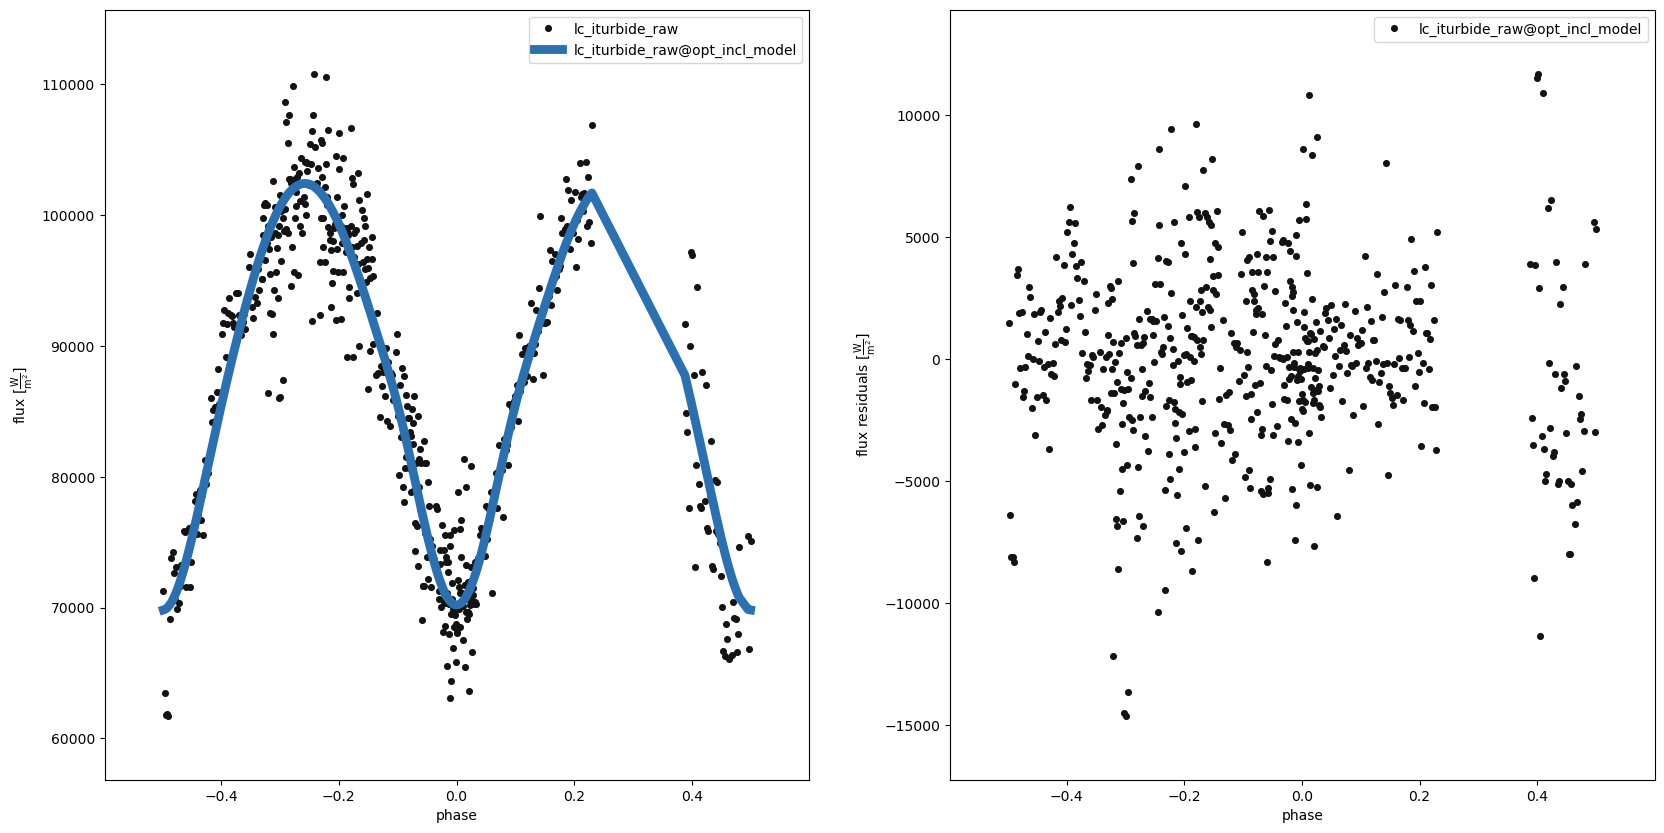

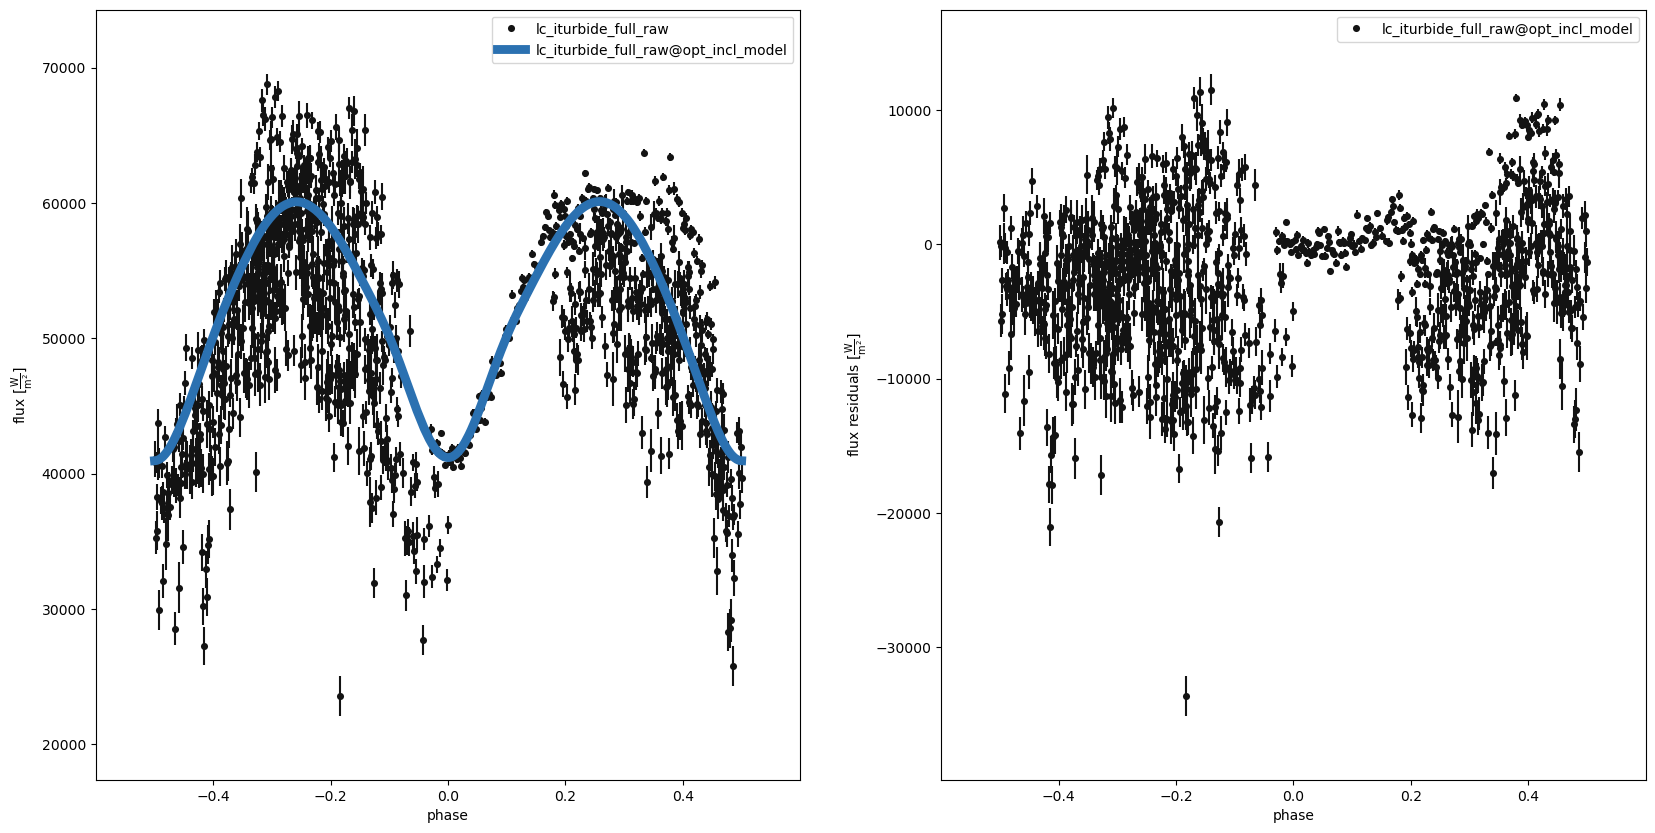

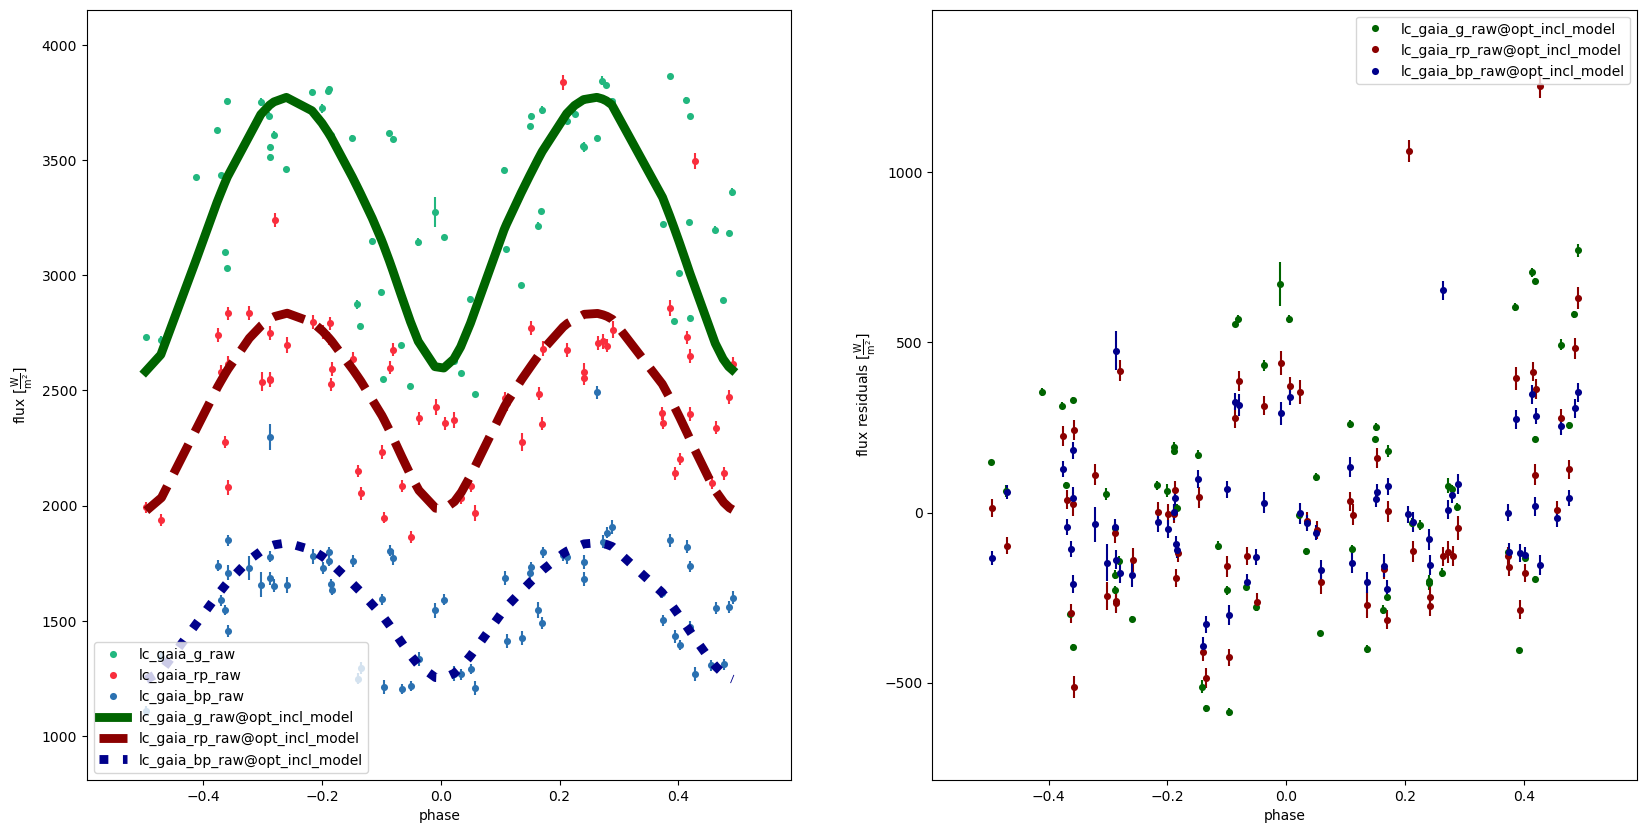

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

full_default
-------------------------------------
raw_model
-------------------------------------
	 Iturbide (Aviles) - 526346844631.68317
	 Gaia - 574823.2231559469
		 lc_gaia_g_raw - 499130.5358300727
		 lc_gaia_rp_raw - 45880.46343980033
		 lc_gaia_bp_raw - 29812.223886073876
before_optimizers
-------------------------------------
	 Iturbide (Aviles) - 9878882142.08559
	 Iturbide (Full) - 65242.231795524516
	 Gaia - 85197.75919673193
		 lc_gaia_g_raw - 73691.14671920484
		 lc_gaia_rp_raw - 7803.467098771015
		 lc_gaia_bp_raw - 3703.145378756079
opt_period_t0_model
-------------------------------------
	 Iturbide (Aviles) - 8396815354.846167
	 Iturbide (Full) - 57121.180083852654
	 Gaia - 77188.51758182517
		 lc_gaia_g_raw - 66206.23421159203
		 lc_gaia_rp_raw - 7463.588528353623
		 lc_gaia_bp_raw - 3518.69484187952
opt_incl_model
-------------------------------------
	 Iturbide (Aviles) - 7724321545.374884
	 Iturbide (Full) - 55160.21078148138
	 Gaia - 71430.21841554053
		 lc_gaia_

In [54]:
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/poro-priors-aviles/results/opt_incl_solution', plot=False, reset_params=False)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=[['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)
printAllModelsChi2(b)

In [53]:
%%script echo "skipping; not much better results than inclination only, and looks to be going to unphysical parameter space (q went pretty high)"
gen_utils.abilitateDatasets(b, allRawDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file='./external-jobs/poro-priors-aviles/results/opt_incl_q_solution', plot=False, reset_params=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 10), datasetGroups=[['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger=logger, model=computeModelName)
printAllModelsChi2(b)

skipping; not much better results than inclination only, and looks to be going to unphysical parameter space (q went pretty high)


## Checkpoint

Saving dataset-scaled bundle; parameters seem to offer a good fit for now.

In [ ]:
gen_utils.saveBundle(b, "dataset-scaled-opt", subfolder="poro-aviles")

## Fitting Temperatures

Adjusting `teff@primary` and `teffratio` using Gaia LCs. Also fitting for Gaia G passband luminosity

In [62]:
pbBackup = b.copy()

In [78]:
%%script echo "skip unless backup restore is needed"
b = pbBackup.copy()

In [79]:
print(b['pblum_mode'])

ParameterSet: 5 parameters
   pblum_mode@lc_iturbide_raw@...: component-coupled
   pblum_mode@lc_gaia_g_raw@da...: component-coupled
   pblum_mode@lc_gaia_rp_raw@d...: dataset-coupled
   pblum_mode@lc_gaia_bp_raw@d...: dataset-coupled
   pblum_mode@lc_iturbide_full...: component-coupled


In [80]:
b.set_value_all(qualifier='pblum_mode', dataset=['lc_iturbide_raw', 'lc_iturbide_full_raw', 'lc_gaia_g_raw'], value='component-coupled')

# coupling Gaia color LCs to Gaia_G
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='lc_gaia_g_raw')

100%|██████████| 1964/1964 [02:55<00:00, 11.17it/s]


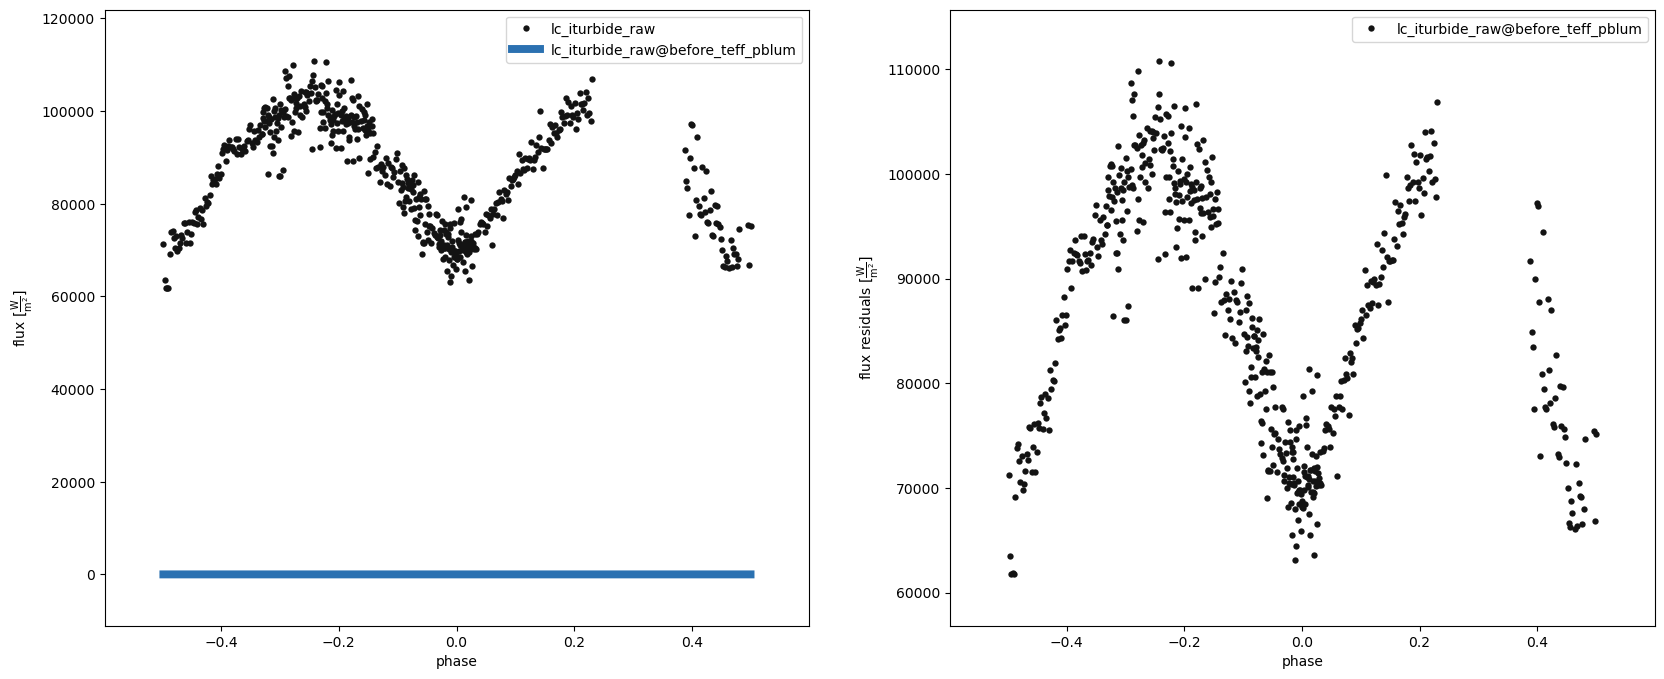

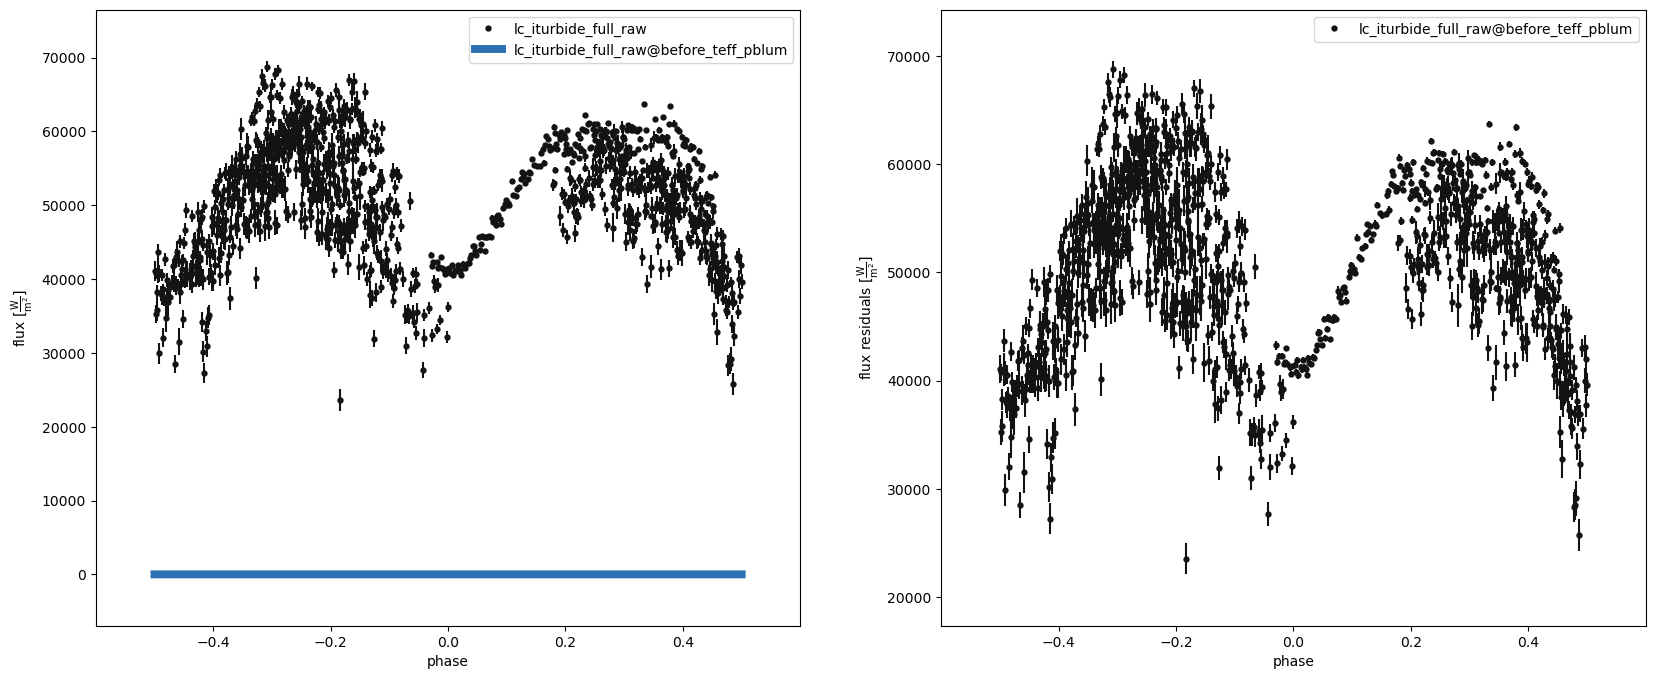

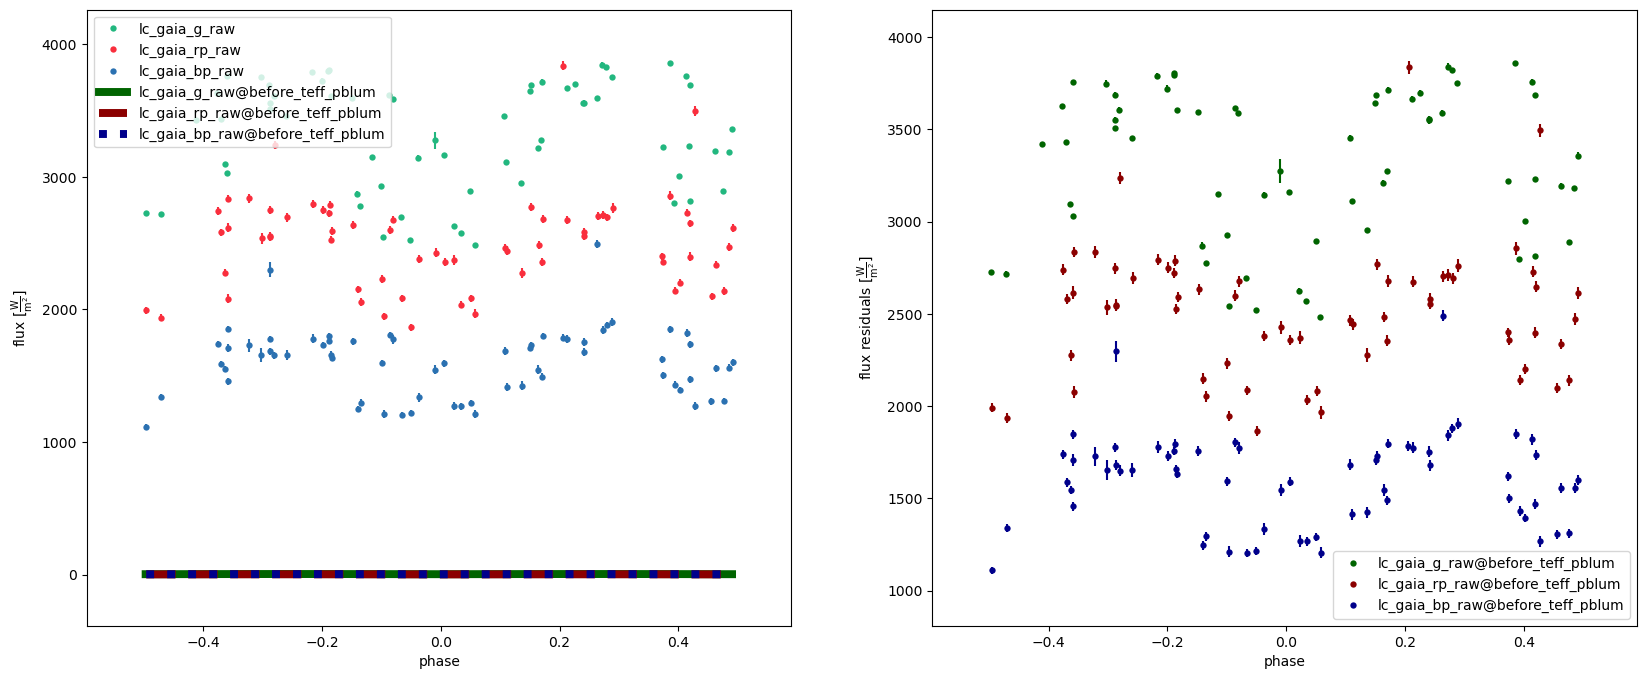

In [82]:
gen_utils.abilitateDatasets(b, allRawDatasets)
b.run_compute(model="before_teff_pblum", overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(20, 8), datasetGroups=[['lc_iturbide_raw'], ['lc_iturbide_full_raw'], rawGaiaDatasets], model="before_teff_pblum")

In [83]:
print(b['teff'])
print(b['teffratio'])
print(b['pblum'])

ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 5973.628259070531 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.112795884727 high=5826.126240382796 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>
Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 0.9956047098450885
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

ParameterSet: 3 parameters
   pblum@primary@lc_iturbide_r...: 12.566370614359172 W
   pblum@primary@lc_gaia_g_raw...: 12.566370614359172 W
   pblum@primary@lc_iturbide_f...: 12.566370614359172 W


 41%|████      | 41/100 [09:33<13:45, 13.98s/it]


Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset = 11492.40137 W

Original values:
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.566370614359172 W


100%|██████████| 213/213 [00:21<00:00,  9.88it/s]


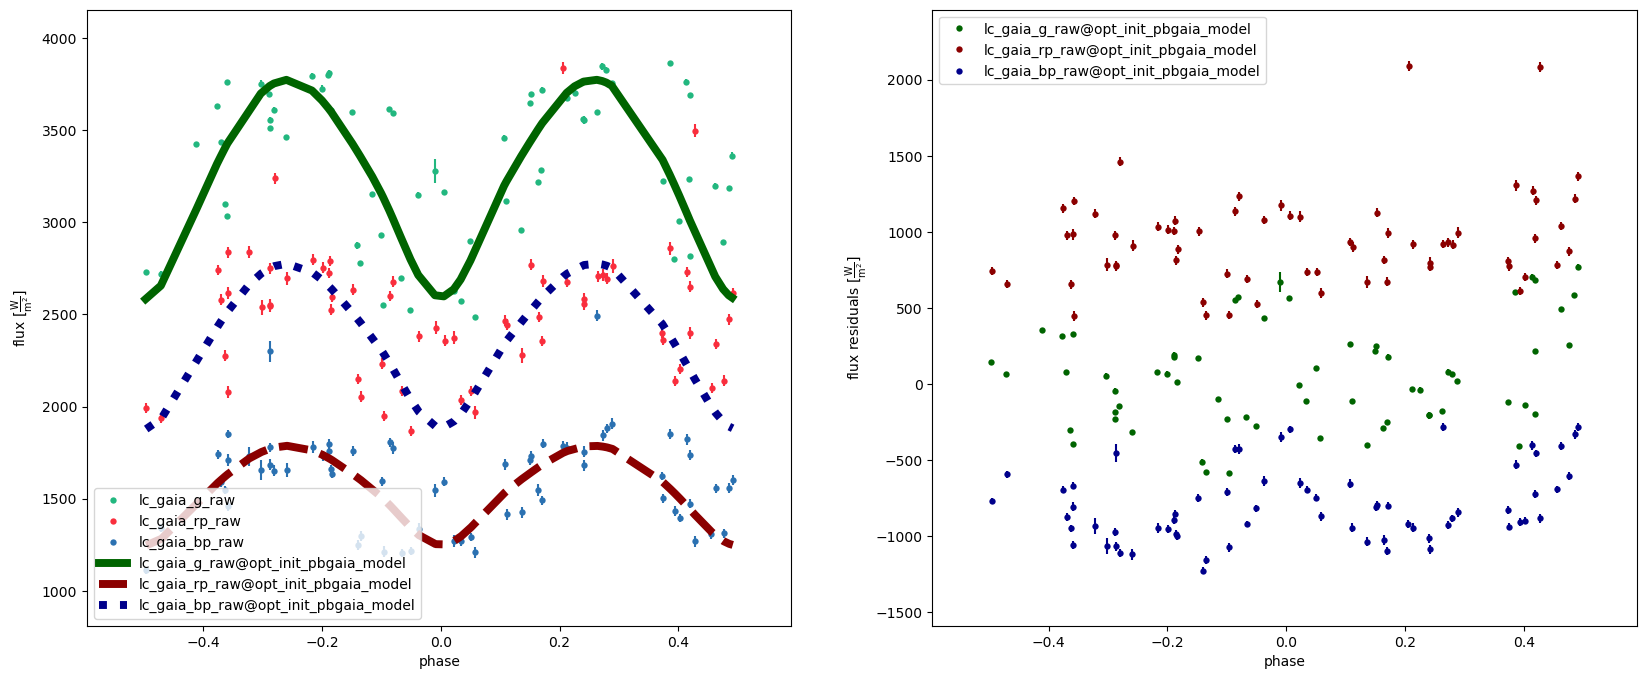

In [85]:
# first couple of iterations to get gaia pblum close enough for follow-up optimizer
# not exporting it since it's a very small, quick optimizer (~10s per iteration)
opt_utils.optimize_params(b, ['pblum@primary@lc_gaia_g_raw'], "init_pbgaia", export=False, datasets=['lc_gaia_g_raw'], maxiter=100)
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, label="init_pbgaia", plot=False,reset_params=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), [rawGaiaDatasets], model=computeModelName)

In [90]:
gaiaBackup = b.copy()

### Adjusting luminosity and temperature alongside a third light factor

Fitting for Gaia luminosities and star temperatures directly results in very cool stars (~4000 K, ~1 `teffratio`). While this fits the data well, these are not
physical values expected based on the system's magnitude and current assumed classification (based on light curve rough shape). Here we will introduce **third light**,
a source of radiation extrinsic to the binary system. Assuming that this unknown source emits significantly in the $G_{RP}$ band, this solution aims to find a 
system with components in the main sequence that fit the observable data.

In [89]:
print(b['l3'])
print(b['l3_mode'])

print()

print(b['l3@lc_gaia_rp_raw'])
print(b['l3_mode@lc_gaia_rp_raw'])

ParameterSet: 5 parameters
       l3@lc_iturbide_raw@dataset: 0.0 W / m2
         l3@lc_gaia_g_raw@dataset: 0.0 W / m2
        l3@lc_gaia_rp_raw@dataset: 0.0 W / m2
        l3@lc_gaia_bp_raw@dataset: 0.0 W / m2
   l3@lc_iturbide_full_raw@dat...: 0.0 W / m2
ParameterSet: 5 parameters
   l3_mode@lc_iturbide_raw@dat...: flux
    l3_mode@lc_gaia_g_raw@dataset: flux
   l3_mode@lc_gaia_rp_raw@dataset: flux
   l3_mode@lc_gaia_bp_raw@dataset: flux
   l3_mode@lc_iturbide_full_ra...: flux

Parameter: l3@lc_gaia_rp_raw@dataset
                       Qualifier: l3
                     Description: Third light in flux units
                           Value: 0.0 W / m2
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: l3_mode:flux

Parameter: l3_mode@lc_gaia_rp_raw@dataset
                       Qualifier: l3_mode
                     Description: Whether third light is given in units of flux or as a fra

In [92]:
# trying first to fit a third light source as a fraction of total light
b.set_value(qualifier='l3_mode', dataset='lc_gaia_rp_raw', value='fraction')

In [98]:
print(b['l3_frac@lc_gaia_rp_raw']) # use this for fraction

Parameter: l3_frac@lc_gaia_rp_raw@dataset
                       Qualifier: l3_frac
                     Description: Third light as a fraction of total flux (both system and third light)
                           Value: 0.0
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: l3_mode:fraction



In [99]:
teffPrimDist = b.get_value(qualifier='teff', component='primary', context='distribution')
opt_utils.optimize_params(b, ["l3_frac@lc_gaia_rp_raw", "pblum@lc_gaia_g_raw@primary"], label="l3frac_pblum_grp_gg", export=True, 
						  subfolder="poro-priors-aviles/l3", datasets=rawGaiaDatasets, maxiter=500)

# also trying to optimize temperatures at the same time, experimenting to check end result
	# next experiment: if above optimizer doesn't get close enough, optimize temperatures later
		# or even create and run this one after above finishes?
# WILL RUN THIS AS A FOLLOW-UP TO L3 FIT ABOVE
# opt_utils.optimize_params(b, ["l3_frac@lc_gaia_rp_raw", "pblum@lc_gaia_g_raw@primary", "teff@primary", "teffratio"], label="l3frac_pblum_grp_gg_teff", export=True,
# 						  subfolder="poro-priors-aviles/l3", datasets=rawGaiaDatasets, maxiter=500)

External Solver: ./external-jobs/poro-priors-aviles/l3/optimizer.nelder_mead_opt_l3frac_pblum_grp_gg.py ./results/opt_l3frac_pblum_grp_gg_solution
External Solver: ./external-jobs/poro-priors-aviles/l3/optimizer.nelder_mead_opt_l3frac_pblum_grp_gg_teff.py ./results/opt_l3frac_pblum_grp_gg_teff_solution


('opt_l3frac_pblum_grp_gg_teff', 'opt_l3frac_pblum_grp_gg_teff_solution')

Adopted:
l3_frac@lc_gaia_rp_raw@lc@dataset = 0.37255 
pblum@primary@lc_gaia_g_raw@lc@dataset = 11159.75929 W

Original values:
  l3_frac@lc_gaia_rp_raw@lc@dataset 0.0
  pblum@primary@lc_gaia_g_raw@lc@dataset 11492.401365727346 W


100%|██████████| 213/213 [00:21<00:00, 10.10it/s]


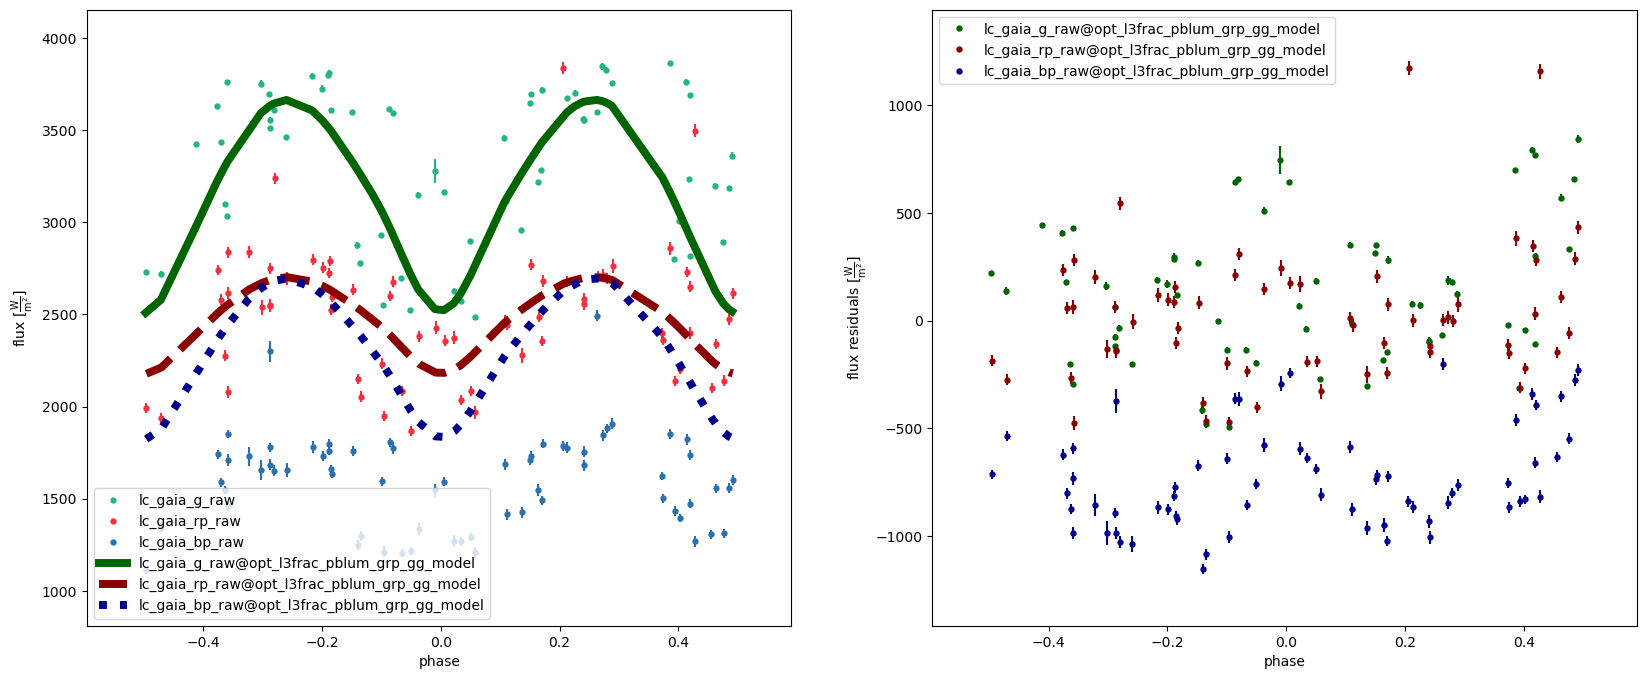

In [108]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors-aviles/l3/results/opt_l3frac_pblum_grp_gg_solution", plot=False, reset_params=False)
gen_utils.plotModelResidualsFigsize(b, (20, 8), datasetGroups=[rawGaiaDatasets], model=computeModelName)

In [109]:
opt_utils.optimize_params(b, ["l3_frac@lc_gaia_rp_raw", "pblum@lc_gaia_g_raw@primary", "teff@primary", "teffratio"], label="l3frac_followup_pblum_grp_gg_teff", export=True,
						  subfolder="poro-priors-aviles/l3", datasets=rawGaiaDatasets, maxiter=500)

External Solver: ./external-jobs/poro-priors-aviles/l3/optimizer.nelder_mead_opt_l3frac_followup_pblum_grp_gg_teff.py ./results/opt_l3frac_followup_pblum_grp_gg_teff_solution


('opt_l3frac_followup_pblum_grp_gg_teff',
 'opt_l3frac_followup_pblum_grp_gg_teff_solution')

In [ ]:
opt_utils.optimize_params(b, ["l3_frac@lc_gaia_rp_raw", "pblum@lc_gaia_g_raw@primary", "teff@primary", "teffratio"], label="l3frac_followup_pblum_grp_gg_teff", export=True,
						  subfolder="poro-priors-aviles/l3", datasets=rawGaiaDatasets, maxiter=500)

Adopted:
l3_frac@lc_gaia_rp_raw@lc@dataset = 0.00000 
pblum@primary@lc_gaia_g_raw@lc@dataset = 11184.40097 W
teff@primary@star@component = 3906.32387 K
teffratio@binary@orbit@component = 1.00394 

Original values:
  l3_frac@lc_gaia_rp_raw@lc@dataset 0.0
  pblum@primary@lc_gaia_g_raw@lc@dataset 11492.401365727346 W
  teff@primary@star@component 6000.0 K
  teffratio@binary@orbit@component 0.9956047098450885


100%|██████████| 213/213 [00:18<00:00, 11.41it/s]


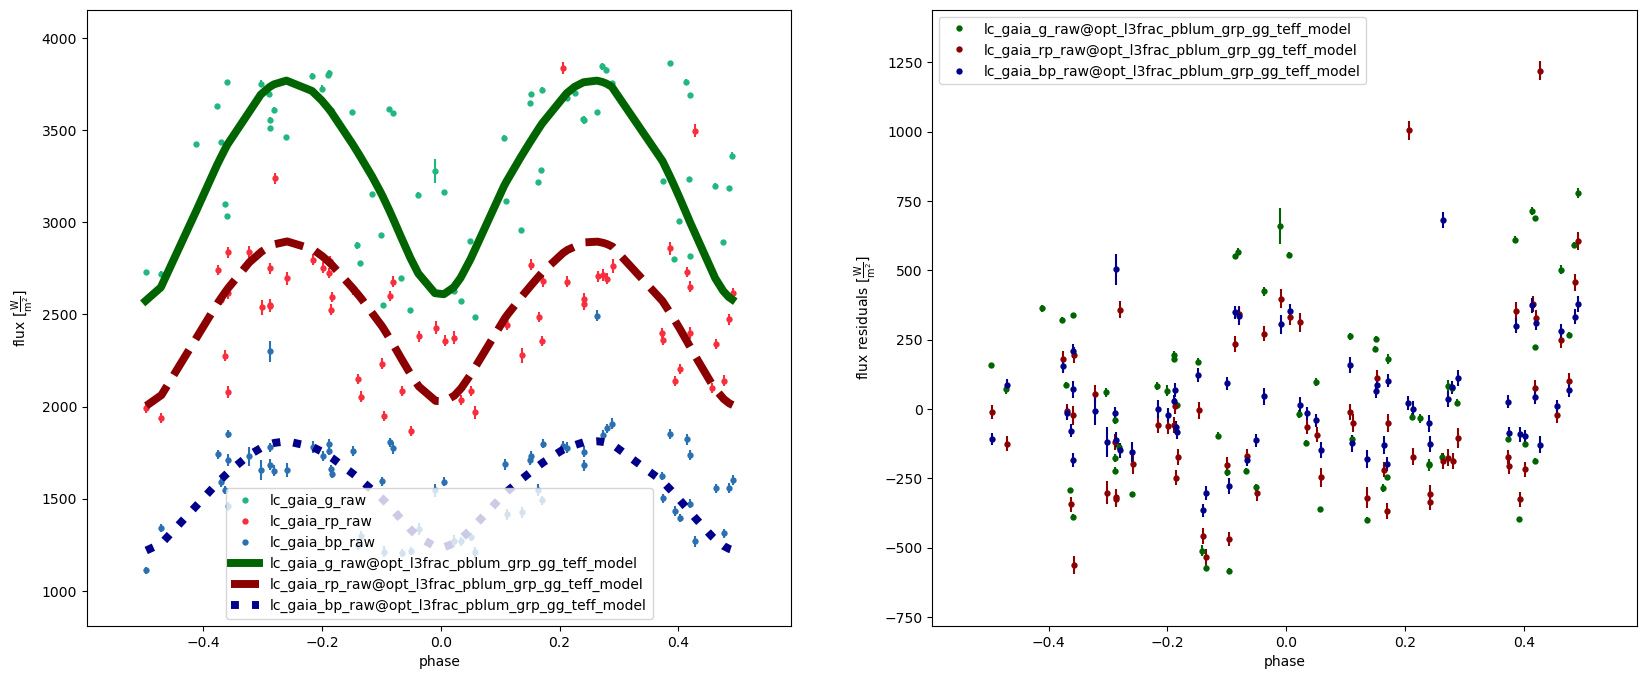

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 5973.628259070531 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.112795884727 high=5826.126240382796 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>


In [112]:
%%script echo "DO NOT USE; got same result as adjusting only pblum and teff (no third light found)"
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/poro-priors-aviles/l3/results/opt_l3frac_pblum_grp_gg_teff_solution", plot=False, reset_params=True)
b.run_all_constraints()
gen_utils.plotModelResidualsFigsize(b, (20, 8), datasetGroups=[rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)
print(b['teff'])

In [115]:
print(b['mass'])
print(b['q'])
print(b['requiv'])
print(b['sma@binary'])

ParameterSet: 4 parameters
           mass@primary@component: 1.0087816199638129 solMass
C        mass@secondary@component: 3.525636912291515 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0682593994618288 high=1.1762906068747014 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>
Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 3.494945627992298
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@primary@component, asini@primary@component, requiv_max@primary@component

#### Testing third light with **all** Gaia bands

Including `incl@binary` in optimization to offset the flattening effects of third light.

100%|██████████| 213/213 [00:23<00:00,  9.03it/s]


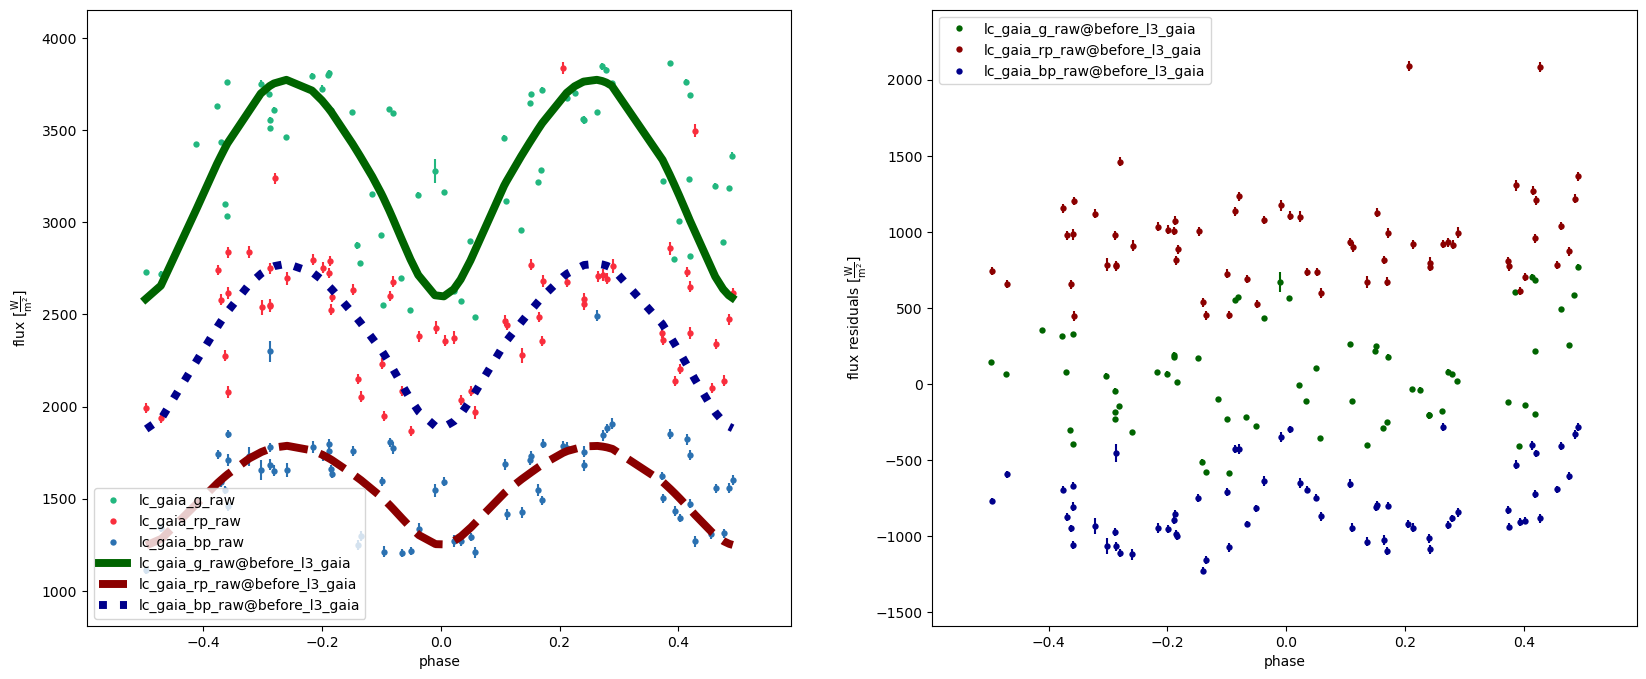

In [116]:
b.run_compute(model="before_l3_gaia", overwrite=True)
gen_utils.plotModelResidualsFigsize(b, (20, 8), [rawGaiaDatasets], model="before_l3_gaia")

In [118]:
b.set_value_all(qualifier='l3_mode', dataset=rawGaiaDatasets, value='fraction')
print(b['l3_mode'])
print(b['l3_frac'])

ParameterSet: 5 parameters
   l3_mode@lc_iturbide_raw@dat...: flux
    l3_mode@lc_gaia_g_raw@dataset: fraction
   l3_mode@lc_gaia_rp_raw@dataset: fraction
   l3_mode@lc_gaia_bp_raw@dataset: fraction
   l3_mode@lc_iturbide_full_ra...: flux
ParameterSet: 3 parameters
    l3_frac@lc_gaia_g_raw@dataset: 0.0
   l3_frac@lc_gaia_rp_raw@dataset: 0.0
   l3_frac@lc_gaia_bp_raw@dataset: 0.0


In [119]:
l3FracTwigs = [f"l3_frac@{d}" for d in rawGaiaDatasets]
opt_utils.optimize_params(b, l3FracTwigs + ['incl@binary', 'pblum@primary@lc_gaia_g_raw'], label="l3gaia_incl", export=True, 
						  subfolder="poro-priors-aviles/l3", datasets=rawGaiaDatasets, maxiter=1000)

# including q, similar effect as inclination
opt_utils.optimize_params(b, l3FracTwigs + ['incl@binary', 'pblum@primary@lc_gaia_g_raw', 'q'], label="l3gaia_incl_q", export=True, 
						  subfolder="poro-priors-aviles/l3", datasets=rawGaiaDatasets, maxiter=1000)

# including teff to see if it has an effect, might reach the same conclusion as before
opt_utils.optimize_params(b, l3FracTwigs + ['incl@binary', 'pblum@primary@lc_gaia_g_raw', 'teff@primary', 'teffratio'], label="l3gaia_incl_teff", export=True, 
						  subfolder="poro-priors-aviles/l3", datasets=rawGaiaDatasets, maxiter=1000)

External Solver: ./external-jobs/poro-priors-aviles/l3/optimizer.nelder_mead_opt_l3gaia_incl.py ./results/opt_l3gaia_incl_solution
External Solver: ./external-jobs/poro-priors-aviles/l3/optimizer.nelder_mead_opt_l3gaia_incl_q.py ./results/opt_l3gaia_incl_q_solution
External Solver: ./external-jobs/poro-priors-aviles/l3/optimizer.nelder_mead_opt_l3gaia_incl_teff.py ./results/opt_l3gaia_incl_teff_solution


('opt_l3gaia_incl_teff', 'opt_l3gaia_incl_teff_solution')

opt_l3gaia_incl_q_solution
--------------------------------------
Adopted:
l3_frac@lc_gaia_g_raw@lc@dataset = 0.00053 
l3_frac@lc_gaia_rp_raw@lc@dataset = 0.00095 
l3_frac@lc_gaia_bp_raw@lc@dataset = 0.00056 
incl@binary@orbit@component = 60.39999 deg
pblum@primary@lc_gaia_g_raw@lc@dataset = 10993.01113 W
q@binary@orbit@component = 3.40704 

Original values:
  l3_frac@lc_gaia_g_raw@lc@dataset 0.0
  l3_frac@lc_gaia_rp_raw@lc@dataset 0.0
  l3_frac@lc_gaia_bp_raw@lc@dataset 0.0
  incl@binary@orbit@component 69.14421485456933 deg
  pblum@primary@lc_gaia_g_raw@lc@dataset 11492.401365727346 W
  q@binary@orbit@component 3.494945627992298


100%|██████████| 213/213 [00:16<00:00, 12.94it/s]


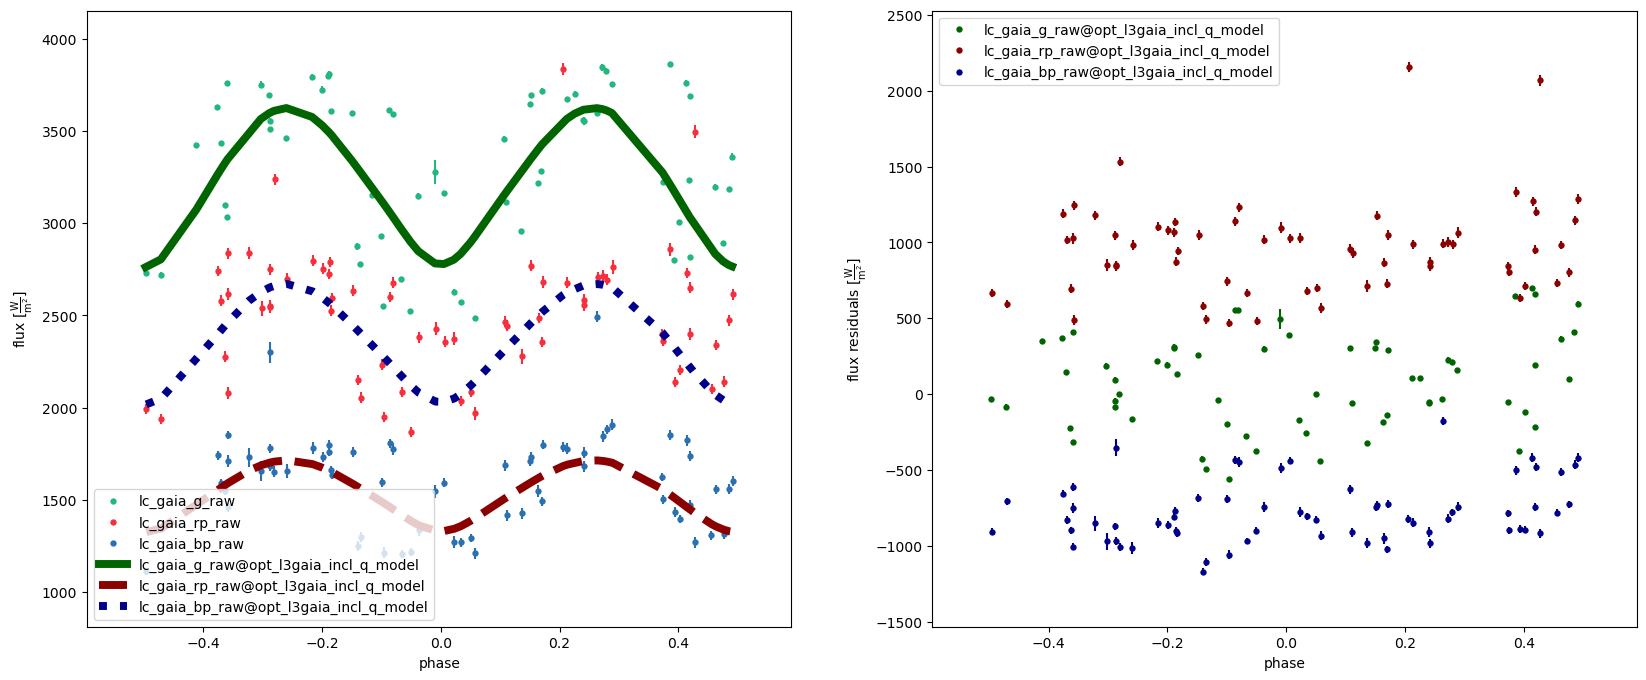

opt_l3gaia_incl_q_model
-------------------------------------
	 Gaia - 189732.33470623707
		 lc_gaia_g_raw - 54866.56578809691
		 lc_gaia_rp_raw - 73009.25119712233
		 lc_gaia_bp_raw - 61856.51772101783
opt_l3gaia_incl_teff_solution
--------------------------------------
Adopted:
l3_frac@lc_gaia_g_raw@lc@dataset = 0.00000 
l3_frac@lc_gaia_rp_raw@lc@dataset = 0.00063 
l3_frac@lc_gaia_bp_raw@lc@dataset = 0.00204 
incl@binary@orbit@component = 57.12788 deg
pblum@primary@lc_gaia_g_raw@lc@dataset = 12540.40175 W
teff@primary@star@component = 4129.73543 K
teffratio@binary@orbit@component = 0.95110 

Original values:
  l3_frac@lc_gaia_g_raw@lc@dataset 0.0
  l3_frac@lc_gaia_rp_raw@lc@dataset 0.0
  l3_frac@lc_gaia_bp_raw@lc@dataset 0.0
  incl@binary@orbit@component 69.14421485456933 deg
  pblum@primary@lc_gaia_g_raw@lc@dataset 11492.401365727346 W
  teff@primary@star@component 6000.0 K
  teffratio@binary@orbit@component 0.9956047098450885


100%|██████████| 213/213 [00:15<00:00, 13.67it/s]


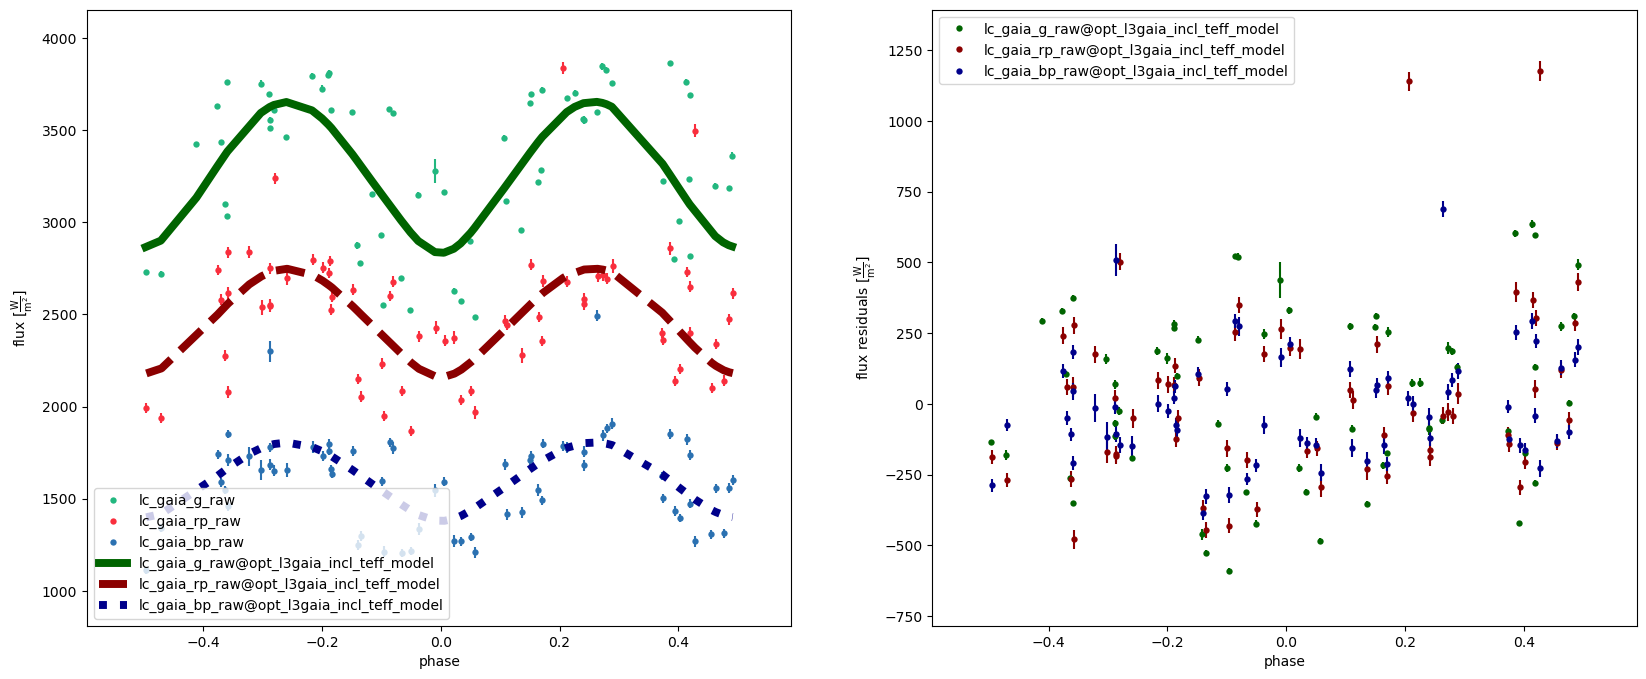

opt_l3gaia_incl_teff_model
-------------------------------------
	 Gaia - 62802.54155485063
		 lc_gaia_g_raw - 53420.58726887234
		 lc_gaia_rp_raw - 6121.4837046136245
		 lc_gaia_bp_raw - 3260.4705813646656
opt_l3gaia_incl_solution
--------------------------------------
Adopted:
l3_frac@lc_gaia_g_raw@lc@dataset = 0.00222 
l3_frac@lc_gaia_rp_raw@lc@dataset = 0.00175 
l3_frac@lc_gaia_bp_raw@lc@dataset = 0.00000 
incl@binary@orbit@component = 60.91082 deg
pblum@primary@lc_gaia_g_raw@lc@dataset = 10780.60225 W

Original values:
  l3_frac@lc_gaia_g_raw@lc@dataset 0.0
  l3_frac@lc_gaia_rp_raw@lc@dataset 0.0
  l3_frac@lc_gaia_bp_raw@lc@dataset 0.0
  incl@binary@orbit@component 69.14421485456933 deg
  pblum@primary@lc_gaia_g_raw@lc@dataset 11492.401365727346 W


100%|██████████| 213/213 [00:16<00:00, 12.55it/s]


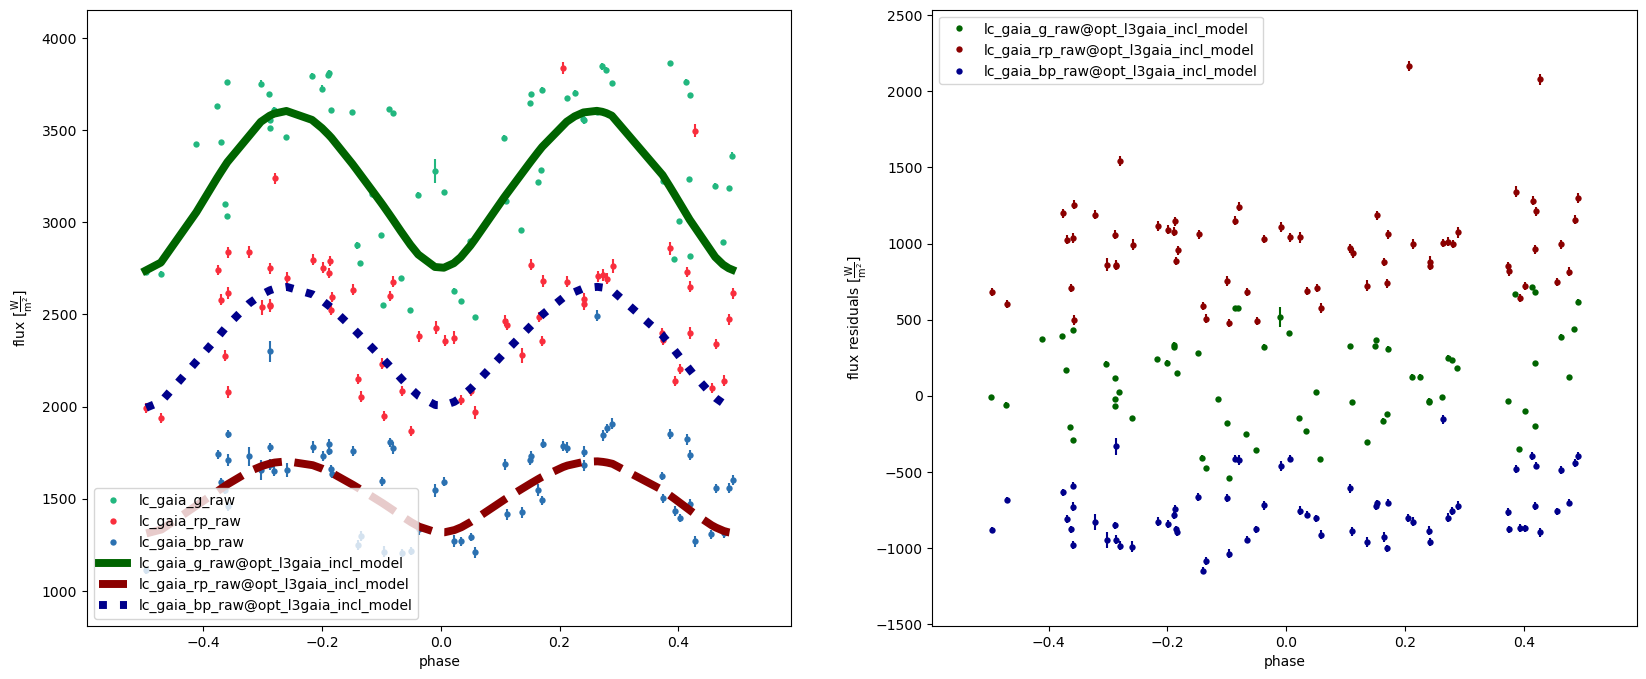

opt_l3gaia_incl_model
-------------------------------------
	 Gaia - 189266.64929540816
		 lc_gaia_g_raw - 55946.0869088128
		 lc_gaia_rp_raw - 74561.1948871353
		 lc_gaia_bp_raw - 58759.36749946007


In [122]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets)
for f in os.listdir("./external-jobs/poro-priors-aviles/l3/results"):
	if "l3gaia" not in f:
		continue
	print(f, "--------------------------------------", sep='\n')
	solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file=f"./external-jobs/poro-priors-aviles/l3/results/{f}", plot=False, reset_params=True)
	gen_utils.plotModelResidualsFigsize(b, (20, 8), datasetGroups=[rawGaiaDatasets], model=computeModelName)
	printChi2(b, computeModelName)

### Fitting luminosities and temperatures directly

Adjusting the components' temperatures to fit their color index based on Gaia light curves.

**Produces very cool stars (~4000 K)**

In [91]:
b_nol3 = gaiaBackup.copy()

In [70]:
teffPrimDist = b_nol3.get_value(qualifier='teff', component='primary', context='distribution')
opt_utils.optimize_params(b_nol3, ['teff@primary', 'teffratio', 'pblum@primary@lc_gaia_g_raw'], "tprim_tratio_pbgaia", 
						  export=True, subfolder="poro-priors-aviles", datasets=rawGaiaDatasets, maxiter=1000,
						  initial_values={'teff@primary': teffPrimDist.sample()})
print(b['teff'])

External Solver: ./external-jobs/poro-priors-aviles/optimizer.nelder_mead_opt_tprim_tratio_pbgaia.py ./results/opt_tprim_tratio_pbgaia_solution
ParameterSet: 4 parameters
           teff@primary@component: 6000.0 K
C        teff@secondary@component: 5973.628259070531 K
                  teff@constraint: {teffratio@binary@component} * {teff@primary@component}
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.112795884727 high=5826.126240382796 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>


Adopted:
teff@primary@star@component = 3905.64543 K
teffratio@binary@orbit@component = 1.00277 
pblum@primary@lc_gaia_g_raw@lc@dataset = 11223.72202 W

Original values:
  teff@primary@star@component 5693.053264328285 K
  teffratio@binary@orbit@component 0.9956047098450885
  pblum@primary@lc_gaia_g_raw@lc@dataset 11492.401365727346 W


100%|██████████| 213/213 [00:16<00:00, 13.17it/s]


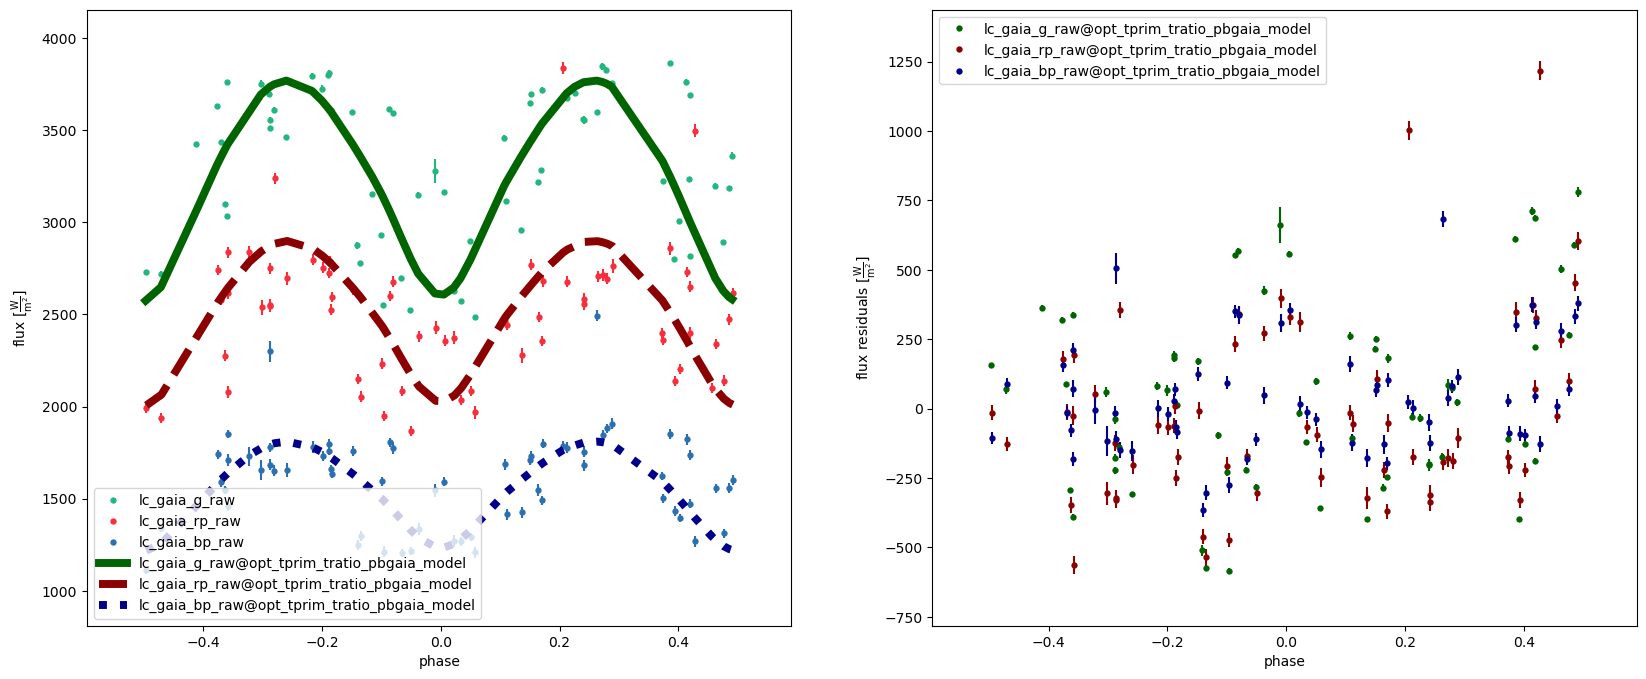

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [77]:
gen_utils.abilitateDatasets(b_nol3, rawGaiaDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b_nol3, solution_file="./external-jobs/poro-priors-aviles/results/opt_tprim_tratio_pbgaia_solution", plot=False, reset_params=True)
gen_utils.plotModelResidualsFigsize(b_nol3, (20, 8), [rawGaiaDatasets], model=computeModelName)
gen_utils.animateMesh(b_nol3, logger, model=computeModelName)